# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [2]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

# import qapf.qapf as qapf
# import statistics.ttest as ttest
# import statistics.simulations as sim

import toolbox.toolbox as tb

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

**Remark below**

In [4]:
# You only need to run this cell once if you want to have multiple outputs in all your notebooks.
# It is a general setting so you can set this cell's status to 'raw'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
coordinates_latlon = preproc.load_obj("coordinates_area1")
coordinates_utm = preproc.load_obj("coordinates_utm_area1")
mineralogy = preproc.load_obj("mineralogy_area1")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area1")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area1")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area1_df")
metadata = preproc.load_obj("metadata_area1")

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## EDA
___

In [6]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

1623

In [7]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
2,1.821303e+06,6.200332e+06,47,T
6,1.535772e+06,5.720315e+06,47,T
9,1.494699e+06,5.662479e+06,47,T
10,1.517471e+06,5.756836e+06,47,T
11,1.327741e+06,5.680599e+06,47,T
...,...,...,...,...
4538,1.706776e+06,5.987458e+06,47,T
4552,1.719854e+06,6.116524e+06,47,T
4574,1.805573e+06,6.115374e+06,47,T
4585,1.850996e+06,6.089380e+06,47,T


In [8]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

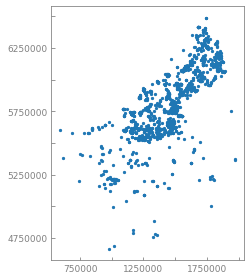

In [8]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area1"

# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [9]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([47], dtype=int64)

array(['T'], dtype=object)

**So you appear to have data points with the exact same location? --> min_lag_distance=0  
This may be what is causing the linalg error later on but need to check it in more detail.  
If I remember correctly, I also encoutered this error when I started of with my datasets.  
Will look into it and (hopefully) get you a solution tomorrow.**

In [10]:
# Calculate minimum and maxmin lag distance between two points of the dataset
min_lag_distance = np.amin(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]]))
max_lag_distance = np.amax(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]]))
min_lag_distance, max_lag_distance

(0.0, 1972727.5695332)

In [11]:
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

In [12]:
distance_matrix[17][:100]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,  1185.6472526 ,  1185.68097724,
        1185.68097724,  1185.68097724,  1876.29880213,  1876.29880213,
        1876.31020108,  2219.44064622,  2371.26080371,  3935.36563641,
        3935.36563641,  7505.12682375,  9069.24325719, 11257.62185991,
       15196.11592047, 16134.05112547, 16134.05112547, 18317.5241583 ,
       18762.47521743, 19349.38650596, 20940.83391369, 22095.22474625,
       23221.29761582, 23247.61575035, 24390.99563951, 24508.42273572,
       25047.19189595, 25735.86460682, 25735.86460682, 26335.50681093,
       26459.49421125, 26459.49421125, 27103.95974462, 27689.25739335,
       28243.25739479, 28513.24208693, 28759.56247791, 28759.56247791,
       28982.15453023, 29021.25686223, 29421.25948003, 30144.67788059,
       30219.52733443, 30510.73908259, 30597.96520691, 30843.43003081,
      

In [13]:
np.where(distance_matrix == 0)

(array([   0,   17,   17,   17,   17,   17,   17,   17,   17,   17,   17,
          22,   28,   28,   32,   34,   34,   34,   34,   35,   35,   35,
          35,   36,   39,   39,   44,   49,   55,   59,   61,   65,   68,
          71,   71,   80,   88,   93,  100,  101,  103,  108,  109,  111,
         115,  117,  117,  117,  118,  120,  122,  122,  122,  122,  123,
         123,  123,  123,  127,  131,  134,  134,  134,  136,  138,  144,
         144,  144,  144,  144,  144,  144,  144,  144,  144,  148,  153,
         154,  158,  163,  165,  167,  167,  178,  180,  181,  190,  190,
         190,  191,  194,  194,  194,  194,  195,  195,  200,  200,  205,
         205,  205,  205,  207,  207,  213,  215,  216,  222,  222,  222,
         224,  226,  232,  232,  232,  232,  232,  233,  241,  241,  241,
         242,  242,  242,  251,  251,  251,  263,  264,  264,  264,  267,
         267,  267,  267,  268,  268,  286,  286,  286,  286,  293,  296,
         299,  302,  305,  305,  305, 

## Critical distance estimation
___

In [14]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 5000

In [15]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
range_ = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

In [16]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)

____

In [17]:
# Create dataframe with duplicates grouping and count info
# https://stackoverflow.com/questions/53760860/pd-duplicated-groups-of-duplicates
cols = ["X", "Y"]
df1 = coordinates_utm[coordinates_utm.duplicated(subset=cols, keep=False)].copy()
df1 = df1.sort_values(cols)
df1['group'] = 'g' + (df1.groupby(cols).ngroup() + 1).astype(str)
# df1['group'] = 'g' + f"{df1['group'].str()[1:]:02d}"
df1['duplicate_count'] = df1.groupby(cols)['X'].transform('size')

In [18]:
df1.sort_index().sort_values(by="duplicate_count", ascending=False)

,X,Y,ZoneNumber,ZoneLetter,group,duplicate_count
46,1.502625e+06,5.740472e+06,47,T,g92,11
990,1.502625e+06,5.740472e+06,47,T,g92,11
366,1.502625e+06,5.740472e+06,47,T,g92,11
1021,1.502625e+06,5.740472e+06,47,T,g92,11
1073,1.502625e+06,5.740472e+06,47,T,g92,11
...,...,...,...,...,...,...
1457,1.657824e+06,6.071950e+06,47,T,g130,2
1467,1.275640e+06,5.561160e+06,47,T,g39,2
1498,1.147662e+06,5.362286e+06,47,T,g14,2
1503,1.578523e+06,6.086366e+06,47,T,g111,2


In [ ]:
# Manual check for first found duplicate group in scans of Vistelius
1121 50°18' 103°25' Bt granite. Mz. Pervomaysky stock. Oth.:so3-0.70 (D.Zhalsabon,1964).
74.06 0.14 12.57 o. 77 0.51 0.06 1.00 0.92 3.24 5.84 0.06 0.65 0.70 100.52
1364 50°18' 103°25' Bt granite. Mz. Pervomaysky stock. Oth.:S03-0.19 (D.Zhalsabon,1964).
73.50 0.16 13.28 1.35 0.51 0.06 1.33 0.92 2.88 6.13 0.04 0.46 0.19 100.81

In [19]:
# Get list of duplicate groups which hold list of corresponding items
group_items = df1.groupby("group").apply(lambda x: x.index.tolist())
group_items

group
g1                 [1121, 1364]
g10                   [59, 288]
g100               [3394, 3531]
g101                 [84, 2923]
g102               [1965, 2185]
                 ...           
g95          [1417, 2821, 3763]
g96          [2227, 2500, 2929]
g97                 [535, 4078]
g98     [730, 2065, 4032, 4244]
g99                [1419, 1954]
Length: 146, dtype: object

In [20]:
group_items_df = pd.DataFrame(group_items)

In [21]:
# Create dictionary of droup items for easy reference
group_items_dict = {k:v for (k, v) in zip(group_items.index, group_items.values)}

In [22]:
for group, items in group_items_dict.items():
    print(group)
    coordinates_latlon.loc[items, :]

g1


,Latitude,Longitude,past_mer,Y,X
1121,"50°18'0.0""","103°25'0.0""",NaN,50.3,103.416667
1364,"50°18'0.0""","103°25'0.0""",NaN,50.3,103.416667


g10


,Latitude,Longitude,past_mer,Y,X
59,"51°45'30.0""","107°35'0.0""",NaN,51.758333,107.583333
288,"51°45'30.0""","107°35'0.0""",NaN,51.758333,107.583333


g100


,Latitude,Longitude,past_mer,Y,X
3394,"52°24'0.0""","114°15'50.0""",NaN,52.4,114.263889
3531,"52°24'0.0""","114°15'50.0""",NaN,52.4,114.263889


g101


,Latitude,Longitude,past_mer,Y,X
84,"52°23'15.0""","114°15'40.0""",NaN,52.3875,114.261111
2923,"52°23'15.0""","114°15'40.0""",NaN,52.3875,114.261111


g102


,Latitude,Longitude,past_mer,Y,X
1965,"52°24'30.0""","114°17'0.0""",NaN,52.408333,114.283333
2185,"52°24'30.0""","114°17'0.0""",NaN,52.408333,114.283333


g103


,Latitude,Longitude,past_mer,Y,X
1329,"52°20'40.0""","114°19'0.0""",NaN,52.344444,114.316667
1635,"52°20'40.0""","114°19'0.0""",NaN,52.344444,114.316667


g104


,Latitude,Longitude,past_mer,Y,X
1326,"50°36'0.0""","113°53'0.0""",NaN,50.6,113.883333
2976,"50°36'0.0""","113°53'0.0""",NaN,50.6,113.883333


g105


,Latitude,Longitude,past_mer,Y,X
569,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9
794,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9
1001,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9
1544,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9
1690,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9
1862,"50°36'0.0""","113°54'0.0""",NaN,50.6,113.9


g106


,Latitude,Longitude,past_mer,Y,X
1025,"53°41'10.0""","115°5'20.0""",NaN,53.686111,115.088889
1612,"53°41'10.0""","115°5'20.0""",NaN,53.686111,115.088889
2611,"53°41'10.0""","115°5'20.0""",NaN,53.686111,115.088889


g107


,Latitude,Longitude,past_mer,Y,X
300,"53°41'50.0""","115°6'10.0""",NaN,53.697222,115.102778
1180,"53°41'50.0""","115°6'10.0""",NaN,53.697222,115.102778


g108


,Latitude,Longitude,past_mer,Y,X
1161,"53°43'0.0""","115°10'0.0""",NaN,53.716667,115.166667
1557,"53°43'0.0""","115°10'0.0""",NaN,53.716667,115.166667


g109


,Latitude,Longitude,past_mer,Y,X
1209,"53°43'0.0""","115°12'10.0""",NaN,53.716667,115.202778
1697,"53°43'0.0""","115°12'10.0""",NaN,53.716667,115.202778


g11


,Latitude,Longitude,past_mer,Y,X
1315,"50°16'30.0""","107°30'0.0""",NaN,50.275,107.5
1709,"50°16'30.0""","107°30'0.0""",NaN,50.275,107.5


g110


,Latitude,Longitude,past_mer,Y,X
176,"53°50'0.0""","115°16'40.0""",NaN,53.833333,115.277778
479,"53°50'0.0""","115°16'40.0""",NaN,53.833333,115.277778


g111


,Latitude,Longitude,past_mer,Y,X
1503,"53°47'20.0""","115°26'30.0""",NaN,53.788889,115.441667
1747,"53°47'20.0""","115°26'30.0""",NaN,53.788889,115.441667


g112


,Latitude,Longitude,past_mer,Y,X
261,"53°54'50.0""","115°33'0.0""",NaN,53.913889,115.55
357,"53°54'50.0""","115°33'0.0""",NaN,53.913889,115.55


g113


,Latitude,Longitude,past_mer,Y,X
1743,"53°57'40.0""","115°34'10.0""",NaN,53.961111,115.569444
1754,"53°57'40.0""","115°34'10.0""",NaN,53.961111,115.569444


g114


,Latitude,Longitude,past_mer,Y,X
3673,"53°57'20.0""","115°35'0.0""",NaN,53.955556,115.583333
3787,"53°57'20.0""","115°35'0.0""",NaN,53.955556,115.583333


g115


,Latitude,Longitude,past_mer,Y,X
419,"53°54'50.0""","115°34'30.0""",NaN,53.913889,115.575
962,"53°54'50.0""","115°34'30.0""",NaN,53.913889,115.575


g116


,Latitude,Longitude,past_mer,Y,X
2203,"53°55'50.0""","115°39'0.0""",NaN,53.930556,115.65
2300,"53°55'50.0""","115°39'0.0""",NaN,53.930556,115.65


g117


,Latitude,Longitude,past_mer,Y,X
3049,"53°55'30.0""","115°39'30.0""",NaN,53.925,115.658333
3502,"53°55'30.0""","115°39'30.0""",NaN,53.925,115.658333


g118


,Latitude,Longitude,past_mer,Y,X
316,"53°57'0.0""","115°42'0.0""",NaN,53.95,115.7
458,"53°57'0.0""","115°42'0.0""",NaN,53.95,115.7


g119


,Latitude,Longitude,past_mer,Y,X
349,"53°55'30.0""","115°42'30.0""",NaN,53.925,115.708333
379,"53°55'30.0""","115°42'30.0""",NaN,53.925,115.708333


g12


,Latitude,Longitude,past_mer,Y,X
741,"48°7'0.0""","107°42'0.0""",NaN,48.116667,107.7
1199,"48°7'0.0""","107°42'0.0""",NaN,48.116667,107.7
2147,"48°7'0.0""","107°42'0.0""",NaN,48.116667,107.7
2549,"48°7'0.0""","107°42'0.0""",NaN,48.116667,107.7


g120


,Latitude,Longitude,past_mer,Y,X
282,"53°55'20.0""","115°42'30.0""",NaN,53.922222,115.708333
635,"53°55'20.0""","115°42'30.0""",NaN,53.922222,115.708333


g121


,Latitude,Longitude,past_mer,Y,X
154,"53°56'10.0""","115°43'0.0""",NaN,53.936111,115.716667
422,"53°56'10.0""","115°43'0.0""",NaN,53.936111,115.716667


g122


,Latitude,Longitude,past_mer,Y,X
394,"53°55'40.0""","115°42'50.0""",NaN,53.927778,115.713889
571,"53°55'40.0""","115°42'50.0""",NaN,53.927778,115.713889


g123


,Latitude,Longitude,past_mer,Y,X
185,"52°34'20.0""","115°15'30.0""",NaN,52.572222,115.258333
213,"52°34'20.0""","115°15'30.0""",NaN,52.572222,115.258333


g124


,Latitude,Longitude,past_mer,Y,X
3222,"52°26'25.0""","115°21'25.0""",NaN,52.440278,115.356944
3355,"52°26'25.0""","115°21'25.0""",NaN,52.440278,115.356944
3408,"52°26'25.0""","115°21'25.0""",NaN,52.440278,115.356944
3818,"52°26'25.0""","115°21'25.0""",NaN,52.440278,115.356944


g125


,Latitude,Longitude,past_mer,Y,X
3302,"52°26'30.0""","115°21'50.0""",NaN,52.441667,115.363889
3775,"52°26'30.0""","115°21'50.0""",NaN,52.441667,115.363889
4450,"52°26'30.0""","115°21'50.0""",NaN,52.441667,115.363889


g126


,Latitude,Longitude,past_mer,Y,X
514,"52°25'10.0""","115°26'27.0""",NaN,52.419444,115.440833
641,"52°25'10.0""","115°26'27.0""",NaN,52.419444,115.440833
683,"52°25'10.0""","115°26'27.0""",NaN,52.419444,115.440833
731,"52°25'10.0""","115°26'27.0""",NaN,52.419444,115.440833
4474,"52°25'10.0""","115°26'27.0""",NaN,52.419444,115.440833


g127


,Latitude,Longitude,past_mer,Y,X
307,"47°14'20.0""","113°54'7.0""",NaN,47.238889,113.901944
776,"47°14'20.0""","113°54'7.0""",NaN,47.238889,113.901944
1889,"47°14'20.0""","113°54'7.0""",NaN,47.238889,113.901944
2536,"47°14'20.0""","113°54'7.0""",NaN,47.238889,113.901944


g128


,Latitude,Longitude,past_mer,Y,X
2796,"53°0'30.0""","116°2'50.0""",NaN,53.008333,116.047222
2806,"53°0'30.0""","116°2'50.0""",NaN,53.008333,116.047222


g129


,Latitude,Longitude,past_mer,Y,X
847,"48°10'0.0""","114°30'0.0""",NaN,48.166667,114.5
1037,"48°10'0.0""","114°30'0.0""",NaN,48.166667,114.5


g13


,Latitude,Longitude,past_mer,Y,X
3413,"50°8'0.0""","108°4'0.0""",NaN,50.133333,108.066667
3432,"50°8'0.0""","108°4'0.0""",NaN,50.133333,108.066667


g130


,Latitude,Longitude,past_mer,Y,X
1397,"53°29'50.0""","116°32'15.0""",NaN,53.497222,116.5375
1457,"53°29'50.0""","116°32'15.0""",NaN,53.497222,116.5375


g131


,Latitude,Longitude,past_mer,Y,X
88,"52°6'50.0""","115°58'30.0""",NaN,52.113889,115.975
95,"52°6'50.0""","115°58'30.0""",NaN,52.113889,115.975
320,"52°6'50.0""","115°58'30.0""",NaN,52.113889,115.975
321,"52°6'50.0""","115°58'30.0""",NaN,52.113889,115.975
1168,"52°6'50.0""","115°58'30.0""",NaN,52.113889,115.975


g132


,Latitude,Longitude,past_mer,Y,X
126,"52°6'50.0""","115°59'20.0""",NaN,52.113889,115.988889
136,"52°6'50.0""","115°59'20.0""",NaN,52.113889,115.988889


g133


,Latitude,Longitude,past_mer,Y,X
1151,"54°19'40.0""","116°57'40.0""",NaN,54.327778,116.961111
3040,"54°19'40.0""","116°57'40.0""",NaN,54.327778,116.961111


g134


,Latitude,Longitude,past_mer,Y,X
1756,"56°20'0.0""","118°16'20.0""",NaN,56.333333,118.272222
3630,"56°20'0.0""","118°16'20.0""",NaN,56.333333,118.272222


g135


,Latitude,Longitude,past_mer,Y,X
346,"53°23'5.0""","116°58'40.0""",NaN,53.384722,116.977778
549,"53°23'5.0""","116°58'40.0""",NaN,53.384722,116.977778
2817,"53°23'5.0""","116°58'40.0""",NaN,53.384722,116.977778
3234,"53°23'5.0""","116°58'40.0""",NaN,53.384722,116.977778


g136


,Latitude,Longitude,past_mer,Y,X
4316,"52°40'30.0""","116°56'10.0""",NaN,52.675,116.936111
4485,"52°40'30.0""","116°56'10.0""",NaN,52.675,116.936111


g137


,Latitude,Longitude,past_mer,Y,X
430,"53°50'30.0""","117°38'20.0""",NaN,53.841667,117.638889
2150,"53°50'30.0""","117°38'20.0""",NaN,53.841667,117.638889
3108,"53°50'30.0""","117°38'20.0""",NaN,53.841667,117.638889


g138


,Latitude,Longitude,past_mer,Y,X
906,"53°51'40.0""","117°39'20.0""",NaN,53.861111,117.655556
1355,"53°51'40.0""","117°39'20.0""",NaN,53.861111,117.655556
1373,"53°51'40.0""","117°39'20.0""",NaN,53.861111,117.655556
2291,"53°51'40.0""","117°39'20.0""",NaN,53.861111,117.655556


g139


,Latitude,Longitude,past_mer,Y,X
2021,"54°4'30.0""","117°50'0.0""",NaN,54.075,117.833333
2072,"54°4'30.0""","117°50'0.0""",NaN,54.075,117.833333
2094,"54°4'30.0""","117°50'0.0""",NaN,54.075,117.833333


g14


,Latitude,Longitude,past_mer,Y,X
1406,"48°5'0.0""","107°42'0.0""",NaN,48.083333,107.7
1498,"48°5'0.0""","107°42'0.0""",NaN,48.083333,107.7


g140


,Latitude,Longitude,past_mer,Y,X
2115,"54°4'10.0""","117°50'0.0""",NaN,54.069444,117.833333
2467,"54°4'10.0""","117°50'0.0""",NaN,54.069444,117.833333


g141


,Latitude,Longitude,past_mer,Y,X
1334,"52°51'0.0""","117°21'0.0""",NaN,52.85,117.35
2244,"52°51'0.0""","117°21'0.0""",NaN,52.85,117.35
2885,"52°51'0.0""","117°21'0.0""",NaN,52.85,117.35


g142


,Latitude,Longitude,past_mer,Y,X
552,"56°10'0.0""","119°4'0.0""",NaN,56.166667,119.066667
557,"56°10'0.0""","119°4'0.0""",NaN,56.166667,119.066667


g143


,Latitude,Longitude,past_mer,Y,X
1795,"53°31'0.0""","118°49'30.0""",NaN,53.516667,118.825
3698,"53°31'0.0""","118°49'30.0""",NaN,53.516667,118.825


g144


,Latitude,Longitude,past_mer,Y,X
2,"54°12'10.0""","119°24'0.0""",NaN,54.202778,119.4
328,"54°12'10.0""","119°24'0.0""",NaN,54.202778,119.4


g145


,Latitude,Longitude,past_mer,Y,X
1241,"54°8'40.0""","119°26'0.0""",NaN,54.144444,119.433333
2181,"54°8'40.0""","119°26'0.0""",NaN,54.144444,119.433333


g146


,Latitude,Longitude,past_mer,Y,X
2281,"53°36'0.0""","119°11'0.0""",NaN,53.6,119.183333
2476,"53°36'0.0""","119°11'0.0""",NaN,53.6,119.183333
2509,"53°36'0.0""","119°11'0.0""",NaN,53.6,119.183333
2714,"53°36'0.0""","119°11'0.0""",NaN,53.6,119.183333


g15


,Latitude,Longitude,past_mer,Y,X
1288,"51°27'0.0""","108°20'0.0""",NaN,51.45,108.333333
1398,"51°27'0.0""","108°20'0.0""",NaN,51.45,108.333333
1490,"51°27'0.0""","108°20'0.0""",NaN,51.45,108.333333


g16


,Latitude,Longitude,past_mer,Y,X
3028,"50°51'0.0""","108°19'0.0""",NaN,50.85,108.316667
3114,"50°51'0.0""","108°19'0.0""",NaN,50.85,108.316667


g17


,Latitude,Longitude,past_mer,Y,X
233,"50°50'0.0""","108°22'0.0""",NaN,50.833333,108.366667
1279,"50°50'0.0""","108°22'0.0""",NaN,50.833333,108.366667


g18


,Latitude,Longitude,past_mer,Y,X
893,"50°50'0.0""","108°23'0.0""",NaN,50.833333,108.383333
1204,"50°50'0.0""","108°23'0.0""",NaN,50.833333,108.383333


g19


,Latitude,Longitude,past_mer,Y,X
2955,"50°12'0.0""","108°17'0.0""",NaN,50.2,108.283333
3286,"50°12'0.0""","108°17'0.0""",NaN,50.2,108.283333


g2


,Latitude,Longitude,past_mer,Y,X
2352,"50°35'0.0""","103°52'40.0""",NaN,50.583333,103.877778
2667,"50°35'0.0""","103°52'40.0""",NaN,50.583333,103.877778


g20


,Latitude,Longitude,past_mer,Y,X
1661,"50°52'0.0""","108°27'0.0""",NaN,50.866667,108.45
2952,"50°52'0.0""","108°27'0.0""",NaN,50.866667,108.45
3198,"50°52'0.0""","108°27'0.0""",NaN,50.866667,108.45


g21


,Latitude,Longitude,past_mer,Y,X
393,"51°28'20.0""","108°40'0.0""",NaN,51.472222,108.666667
455,"51°28'20.0""","108°40'0.0""",NaN,51.472222,108.666667


g22


,Latitude,Longitude,past_mer,Y,X
2599,"50°18'0.0""","108°34'0.0""",NaN,50.3,108.566667
2709,"50°18'0.0""","108°34'0.0""",NaN,50.3,108.566667


g23


,Latitude,Longitude,past_mer,Y,X
1150,"50°27'0.0""","108°38'0.0""",NaN,50.45,108.633333
2008,"50°27'0.0""","108°38'0.0""",NaN,50.45,108.633333


g24


,Latitude,Longitude,past_mer,Y,X
1336,"50°18'0.0""","108°37'0.0""",NaN,50.3,108.616667
2451,"50°18'0.0""","108°37'0.0""",NaN,50.3,108.616667


g25


,Latitude,Longitude,past_mer,Y,X
902,"50°32'0.0""","108°45'0.0""",NaN,50.533333,108.75
4380,"50°32'0.0""","108°45'0.0""",NaN,50.533333,108.75


g26


,Latitude,Longitude,past_mer,Y,X
3593,"50°20'0.0""","108°45'0.0""",NaN,50.333333,108.75
4015,"50°20'0.0""","108°45'0.0""",NaN,50.333333,108.75


g27


,Latitude,Longitude,past_mer,Y,X
1484,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
1813,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
2347,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
2635,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
2659,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
2756,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
2766,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35
3914,"51°19'0.0""","109°21'0.0""",NaN,51.316667,109.35


g28


,Latitude,Longitude,past_mer,Y,X
1708,"51°19'0.0""","109°22'0.0""",NaN,51.316667,109.366667
1876,"51°19'0.0""","109°22'0.0""",NaN,51.316667,109.366667
2001,"51°19'0.0""","109°22'0.0""",NaN,51.316667,109.366667
2288,"51°19'0.0""","109°22'0.0""",NaN,51.316667,109.366667


g29


,Latitude,Longitude,past_mer,Y,X
1313,"51°20'0.0""","109°25'0.0""",NaN,51.333333,109.416667
2252,"51°20'0.0""","109°25'0.0""",NaN,51.333333,109.416667


g3


,Latitude,Longitude,past_mer,Y,X
262,"46°37'0.0""","104°44'0.0""",NaN,46.616667,104.733333
337,"46°37'0.0""","104°44'0.0""",NaN,46.616667,104.733333


g30


,Latitude,Longitude,past_mer,Y,X
1600,"51°19'0.0""","109°26'0.0""",NaN,51.316667,109.433333
1603,"51°19'0.0""","109°26'0.0""",NaN,51.316667,109.433333


g31


,Latitude,Longitude,past_mer,Y,X
1353,"51°23'0.0""","109°27'0.0""",NaN,51.383333,109.45
1487,"51°23'0.0""","109°27'0.0""",NaN,51.383333,109.45
1800,"51°23'0.0""","109°27'0.0""",NaN,51.383333,109.45


g32


,Latitude,Longitude,past_mer,Y,X
1775,"51°23'0.0""","109°31'0.0""",NaN,51.383333,109.516667
1852,"51°23'0.0""","109°31'0.0""",NaN,51.383333,109.516667
1943,"51°23'0.0""","109°31'0.0""",NaN,51.383333,109.516667
2463,"51°23'0.0""","109°31'0.0""",NaN,51.383333,109.516667
3110,"51°23'0.0""","109°31'0.0""",NaN,51.383333,109.516667


g33


,Latitude,Longitude,past_mer,Y,X
879,"45°34'0.0""","108°40'0.0""",NaN,45.566667,108.666667
1906,"45°34'0.0""","108°40'0.0""",NaN,45.566667,108.666667
2230,"45°34'0.0""","108°40'0.0""",NaN,45.566667,108.666667
2381,"45°34'0.0""","108°40'0.0""",NaN,45.566667,108.666667


g34


,Latitude,Longitude,past_mer,Y,X
2020,"49°30'0.0""","109°30'0.0""",NaN,49.5,109.5
3338,"49°30'0.0""","109°30'0.0""",NaN,49.5,109.5


g35


,Latitude,Longitude,past_mer,Y,X
935,"50°3'0.0""","109°42'0.0""",NaN,50.05,109.7
1354,"50°3'0.0""","109°42'0.0""",NaN,50.05,109.7


g36


,Latitude,Longitude,past_mer,Y,X
1165,"47°45'0.0""","109°13'24.0""",NaN,47.75,109.223333
1187,"47°45'0.0""","109°13'24.0""",NaN,47.75,109.223333
2479,"47°45'0.0""","109°13'24.0""",NaN,47.75,109.223333


g37


,Latitude,Longitude,past_mer,Y,X
2547,"50°7'0.0""","109°47'0.0""",NaN,50.116667,109.783333
3659,"50°7'0.0""","109°47'0.0""",NaN,50.116667,109.783333


g38


,Latitude,Longitude,past_mer,Y,X
1159,"50°5'0.0""","109°51'0.0""",NaN,50.083333,109.85
3902,"50°5'0.0""","109°51'0.0""",NaN,50.083333,109.85


g39


,Latitude,Longitude,past_mer,Y,X
1467,"49°42'0.0""","109°46'0.0""",NaN,49.7,109.766667
2301,"49°42'0.0""","109°46'0.0""",NaN,49.7,109.766667


g4


,Latitude,Longitude,past_mer,Y,X
71,"50°44'40.0""","105°18'0.0""",NaN,50.744444,105.3
116,"50°44'40.0""","105°18'0.0""",NaN,50.744444,105.3
497,"50°44'40.0""","105°18'0.0""",NaN,50.744444,105.3


g40


,Latitude,Longitude,past_mer,Y,X
994,"49°41'0.0""","109°46'0.0""",NaN,49.683333,109.766667
1381,"49°41'0.0""","109°46'0.0""",NaN,49.683333,109.766667
2444,"49°41'0.0""","109°46'0.0""",NaN,49.683333,109.766667


g41


,Latitude,Longitude,past_mer,Y,X
1982,"49°43'0.0""","109°48'0.0""",NaN,49.716667,109.8
2492,"49°43'0.0""","109°48'0.0""",NaN,49.716667,109.8


g42


,Latitude,Longitude,past_mer,Y,X
3886,"50°5'0.0""","109°53'0.0""",NaN,50.083333,109.883333
3996,"50°5'0.0""","109°53'0.0""",NaN,50.083333,109.883333


g43


,Latitude,Longitude,past_mer,Y,X
872,"51°1'0.0""","110°11'0.0""",NaN,51.016667,110.183333
1737,"51°1'0.0""","110°11'0.0""",NaN,51.016667,110.183333


g44


,Latitude,Longitude,past_mer,Y,X
3208,"50°14'0.0""","110°5'0.0""",NaN,50.233333,110.083333
3913,"50°14'0.0""","110°5'0.0""",NaN,50.233333,110.083333


g45


,Latitude,Longitude,past_mer,Y,X
1726,"51°20'0.0""","110°22'0.0""",NaN,51.333333,110.366667
1790,"51°20'0.0""","110°22'0.0""",NaN,51.333333,110.366667


g46


,Latitude,Longitude,past_mer,Y,X
151,"50°7'0.0""","110°7'0.0""",NaN,50.116667,110.116667
1320,"50°7'0.0""","110°7'0.0""",NaN,50.116667,110.116667


g47


,Latitude,Longitude,past_mer,Y,X
761,"50°8'0.0""","110°11'0.0""",NaN,50.133333,110.183333
1657,"50°8'0.0""","110°11'0.0""",NaN,50.133333,110.183333


g48


,Latitude,Longitude,past_mer,Y,X
809,"50°7'0.0""","110°11'0.0""",NaN,50.116667,110.183333
1243,"50°7'0.0""","110°11'0.0""",NaN,50.116667,110.183333


g49


,Latitude,Longitude,past_mer,Y,X
709,"49°32'0.0""","110°6'0.0""",NaN,49.533333,110.1
766,"49°32'0.0""","110°6'0.0""",NaN,49.533333,110.1


g5


,Latitude,Longitude,past_mer,Y,X
2566,"46°54'0.0""","105°51'0.0""",NaN,46.9,105.85
2863,"46°54'0.0""","105°51'0.0""",NaN,46.9,105.85


g50


,Latitude,Longitude,past_mer,Y,X
267,"49°31'0.0""","110°6'0.0""",NaN,49.516667,110.1
698,"49°31'0.0""","110°6'0.0""",NaN,49.516667,110.1


g51


,Latitude,Longitude,past_mer,Y,X
250,"46°25'0.0""","109°43'0.0""",NaN,46.416667,109.716667
311,"46°25'0.0""","109°43'0.0""",NaN,46.416667,109.716667


g52


,Latitude,Longitude,past_mer,Y,X
998,"49°29'0.0""","110°48'0.0""",NaN,49.483333,110.8
2802,"49°29'0.0""","110°48'0.0""",NaN,49.483333,110.8


g53


,Latitude,Longitude,past_mer,Y,X
2818,"46°5'0.0""","110°7'0.0""",NaN,46.083333,110.116667
2862,"46°5'0.0""","110°7'0.0""",NaN,46.083333,110.116667
2896,"46°5'0.0""","110°7'0.0""",NaN,46.083333,110.116667


g54


,Latitude,Longitude,past_mer,Y,X
484,"49°38'0.0""","111°3'0.0""",NaN,49.633333,111.05
1899,"49°38'0.0""","111°3'0.0""",NaN,49.633333,111.05
2160,"49°38'0.0""","111°3'0.0""",NaN,49.633333,111.05
2332,"49°38'0.0""","111°3'0.0""",NaN,49.633333,111.05
3696,"49°38'0.0""","111°3'0.0""",NaN,49.633333,111.05


g55


,Latitude,Longitude,past_mer,Y,X
3155,"49°21'0.0""","111°6'0.0""",NaN,49.35,111.1
3577,"49°21'0.0""","111°6'0.0""",NaN,49.35,111.1


g56


,Latitude,Longitude,past_mer,Y,X
2433,"49°59'0.0""","111°28'0.0""",NaN,49.983333,111.466667
3881,"49°59'0.0""","111°28'0.0""",NaN,49.983333,111.466667


g57


,Latitude,Longitude,past_mer,Y,X
283,"52°58'0.0""","112°42'40.0""",NaN,52.966667,112.711111
406,"52°58'0.0""","112°42'40.0""",NaN,52.966667,112.711111


g58


,Latitude,Longitude,past_mer,Y,X
1272,"49°49'0.0""","111°48'0.0""",NaN,49.816667,111.8
1666,"49°49'0.0""","111°48'0.0""",NaN,49.816667,111.8


g59


,Latitude,Longitude,past_mer,Y,X
103,"53°6'30.0""","112°52'40.0""",NaN,53.108333,112.877778
3185,"53°6'30.0""","112°52'40.0""",NaN,53.108333,112.877778


g6


,Latitude,Longitude,past_mer,Y,X
913,"46°50'0.0""","105°55'0.0""",NaN,46.833333,105.916667
1411,"46°50'0.0""","105°55'0.0""",NaN,46.833333,105.916667


g60


,Latitude,Longitude,past_mer,Y,X
1695,"52°42'30.0""","112°46'30.0""",NaN,52.708333,112.775
1752,"52°42'30.0""","112°46'30.0""",NaN,52.708333,112.775


g61


,Latitude,Longitude,past_mer,Y,X
3072,"52°1'0.0""","112°35'0.0""",NaN,52.016667,112.583333
3270,"52°1'0.0""","112°35'0.0""",NaN,52.016667,112.583333


g62


,Latitude,Longitude,past_mer,Y,X
3425,"52°18'0.0""","112°53'0.0""",NaN,52.3,112.883333
3855,"52°18'0.0""","112°53'0.0""",NaN,52.3,112.883333


g63


,Latitude,Longitude,past_mer,Y,X
642,"51°2'0.0""","112°30'0.0""",NaN,51.033333,112.5
894,"51°2'0.0""","112°30'0.0""",NaN,51.033333,112.5
1284,"51°2'0.0""","112°30'0.0""",NaN,51.033333,112.5


g64


,Latitude,Longitude,past_mer,Y,X
2545,"49°38'0.0""","112°7'0.0""",NaN,49.633333,112.116667
2980,"49°38'0.0""","112°7'0.0""",NaN,49.633333,112.116667


g65


,Latitude,Longitude,past_mer,Y,X
3417,"52°15'0.0""","112°55'0.0""",NaN,52.25,112.916667
3780,"52°15'0.0""","112°55'0.0""",NaN,52.25,112.916667


g66


,Latitude,Longitude,past_mer,Y,X
931,"52°21'0.0""","112°57'0.0""",NaN,52.35,112.95
1044,"52°21'0.0""","112°57'0.0""",NaN,52.35,112.95
1333,"52°21'0.0""","112°57'0.0""",NaN,52.35,112.95


g67


,Latitude,Longitude,past_mer,Y,X
3512,"49°38'0.0""","112°9'0.0""",NaN,49.633333,112.15
3828,"49°38'0.0""","112°9'0.0""",NaN,49.633333,112.15
3904,"49°38'0.0""","112°9'0.0""",NaN,49.633333,112.15


g68


,Latitude,Longitude,past_mer,Y,X
3629,"49°39'0.0""","112°11'0.0""",NaN,49.65,112.183333
3739,"49°39'0.0""","112°11'0.0""",NaN,49.65,112.183333


g69


,Latitude,Longitude,past_mer,Y,X
518,"50°10'0.0""","112°25'0.0""",NaN,50.166667,112.416667
1344,"50°10'0.0""","112°25'0.0""",NaN,50.166667,112.416667
1418,"50°10'0.0""","112°25'0.0""",NaN,50.166667,112.416667


g7


,Latitude,Longitude,past_mer,Y,X
637,"46°50'0.0""","105°59'0.0""",NaN,46.833333,105.983333
1420,"46°50'0.0""","105°59'0.0""",NaN,46.833333,105.983333
2030,"46°50'0.0""","105°59'0.0""",NaN,46.833333,105.983333
2399,"46°50'0.0""","105°59'0.0""",NaN,46.833333,105.983333


g70


,Latitude,Longitude,past_mer,Y,X
3142,"49°41'0.0""","112°18'0.0""",NaN,49.683333,112.3
3578,"49°41'0.0""","112°18'0.0""",NaN,49.683333,112.3


g71


,Latitude,Longitude,past_mer,Y,X
1300,"49°36'0.0""","112°19'0.0""",NaN,49.6,112.316667
2156,"49°36'0.0""","112°19'0.0""",NaN,49.6,112.316667


g72


,Latitude,Longitude,past_mer,Y,X
1068,"49°45'0.0""","112°22'0.0""",NaN,49.75,112.366667
1104,"49°45'0.0""","112°22'0.0""",NaN,49.75,112.366667
1171,"49°45'0.0""","112°22'0.0""",NaN,49.75,112.366667


g73


,Latitude,Longitude,past_mer,Y,X
1043,"49°44'0.0""","112°22'0.0""",NaN,49.733333,112.366667
1314,"49°44'0.0""","112°22'0.0""",NaN,49.733333,112.366667


g74


,Latitude,Longitude,past_mer,Y,X
3599,"50°19'0.0""","112°37'0.0""",NaN,50.316667,112.616667
3654,"50°19'0.0""","112°37'0.0""",NaN,50.316667,112.616667


g75


,Latitude,Longitude,past_mer,Y,X
542,"50°0'0.0""","112°32'0.0""",NaN,50.0,112.533333
1595,"50°0'0.0""","112°32'0.0""",NaN,50.0,112.533333


g76


,Latitude,Longitude,past_mer,Y,X
478,"51°9'0.0""","112°55'0.0""",NaN,51.15,112.916667
595,"51°9'0.0""","112°55'0.0""",NaN,51.15,112.916667
610,"51°9'0.0""","112°55'0.0""",NaN,51.15,112.916667
1489,"51°9'0.0""","112°55'0.0""",NaN,51.15,112.916667


g77


,Latitude,Longitude,past_mer,Y,X
1137,"51°8'0.0""","112°56'0.0""",NaN,51.133333,112.933333
1166,"51°8'0.0""","112°56'0.0""",NaN,51.133333,112.933333
1948,"51°8'0.0""","112°56'0.0""",NaN,51.133333,112.933333
2221,"51°8'0.0""","112°56'0.0""",NaN,51.133333,112.933333


g78


,Latitude,Longitude,past_mer,Y,X
1565,"51°9'0.0""","112°57'0.0""",NaN,51.15,112.95
1963,"51°9'0.0""","112°57'0.0""",NaN,51.15,112.95


g79


,Latitude,Longitude,past_mer,Y,X
191,"51°8'0.0""","112°57'0.0""",NaN,51.133333,112.95
989,"51°8'0.0""","112°57'0.0""",NaN,51.133333,112.95
2769,"51°8'0.0""","112°57'0.0""",NaN,51.133333,112.95


g8


,Latitude,Longitude,past_mer,Y,X
1212,"46°50'0.0""","106°10'0.0""",NaN,46.833333,106.166667
2173,"46°50'0.0""","106°10'0.0""",NaN,46.833333,106.166667


g80


,Latitude,Longitude,past_mer,Y,X
144,"46°45'0.0""","111°47'30.0""",NaN,46.75,111.791667
459,"46°45'0.0""","111°47'30.0""",NaN,46.75,111.791667


g81


,Latitude,Longitude,past_mer,Y,X
886,"50°19'0.0""","112°47'0.0""",NaN,50.316667,112.783333
1902,"50°19'0.0""","112°47'0.0""",NaN,50.316667,112.783333


g82


,Latitude,Longitude,past_mer,Y,X
3551,"50°7'0.0""","112°45'0.0""",NaN,50.116667,112.75
3794,"50°7'0.0""","112°45'0.0""",NaN,50.116667,112.75


g83


,Latitude,Longitude,past_mer,Y,X
2448,"51°7'0.0""","113°4'0.0""",NaN,51.116667,113.066667
3115,"51°7'0.0""","113°4'0.0""",NaN,51.116667,113.066667


g84


,Latitude,Longitude,past_mer,Y,X
1956,"51°7'0.0""","113°5'0.0""",NaN,51.116667,113.083333
2519,"51°7'0.0""","113°5'0.0""",NaN,51.116667,113.083333


g85


,Latitude,Longitude,past_mer,Y,X
487,"47°40'0.0""","112°7'0.0""",NaN,47.666667,112.116667
1349,"47°40'0.0""","112°7'0.0""",NaN,47.666667,112.116667
1644,"47°40'0.0""","112°7'0.0""",NaN,47.666667,112.116667


g86


,Latitude,Longitude,past_mer,Y,X
727,"47°32'30.0""","112°10'0.0""",NaN,47.541667,112.166667
1008,"47°32'30.0""","112°10'0.0""",NaN,47.541667,112.166667


g87


,Latitude,Longitude,past_mer,Y,X
2042,"51°4'0.0""","113°13'0.0""",NaN,51.066667,113.216667
2501,"51°4'0.0""","113°13'0.0""",NaN,51.066667,113.216667


g88


,Latitude,Longitude,past_mer,Y,X
1393,"49°54'0.0""","112°55'0.0""",NaN,49.9,112.916667
2200,"49°54'0.0""","112°55'0.0""",NaN,49.9,112.916667
2219,"49°54'0.0""","112°55'0.0""",NaN,49.9,112.916667
3852,"49°54'0.0""","112°55'0.0""",NaN,49.9,112.916667


g89


,Latitude,Longitude,past_mer,Y,X
540,"49°58'0.0""","112°58'0.0""",NaN,49.966667,112.966667
1260,"49°58'0.0""","112°58'0.0""",NaN,49.966667,112.966667


g9


,Latitude,Longitude,past_mer,Y,X
1714,"51°44'0.0""","107°33'50.0""",NaN,51.733333,107.563889
1763,"51°44'0.0""","107°33'50.0""",NaN,51.733333,107.563889


g90


,Latitude,Longitude,past_mer,Y,X
591,"51°26'0.0""","113°27'0.0""",NaN,51.433333,113.45
1328,"51°26'0.0""","113°27'0.0""",NaN,51.433333,113.45
1803,"51°26'0.0""","113°27'0.0""",NaN,51.433333,113.45
3324,"51°26'0.0""","113°27'0.0""",NaN,51.433333,113.45


g91


,Latitude,Longitude,past_mer,Y,X
790,"50°57'0.0""","113°18'0.0""",NaN,50.95,113.3
926,"50°57'0.0""","113°18'0.0""",NaN,50.95,113.3


g92


,Latitude,Longitude,past_mer,Y,X
46,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
366,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
990,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
1021,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
1073,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
1390,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
1402,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
1984,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
2019,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3
2213,"50°56'0.0""","113°18'0.0""",NaN,50.933333,113.3


g93


,Latitude,Longitude,past_mer,Y,X
3378,"51°11'0.0""","113°23'0.0""",NaN,51.183333,113.383333
3619,"51°11'0.0""","113°23'0.0""",NaN,51.183333,113.383333


g94


,Latitude,Longitude,past_mer,Y,X
722,"50°58'0.0""","113°19'0.0""",NaN,50.966667,113.316667
3051,"50°58'0.0""","113°19'0.0""",NaN,50.966667,113.316667


g95


,Latitude,Longitude,past_mer,Y,X
1417,"50°56'0.0""","113°19'0.0""",NaN,50.933333,113.316667
2821,"50°56'0.0""","113°19'0.0""",NaN,50.933333,113.316667
3763,"50°56'0.0""","113°19'0.0""",NaN,50.933333,113.316667


g96


,Latitude,Longitude,past_mer,Y,X
2227,"51°15'0.0""","113°28'0.0""",NaN,51.25,113.466667
2500,"51°15'0.0""","113°28'0.0""",NaN,51.25,113.466667
2929,"51°15'0.0""","113°28'0.0""",NaN,51.25,113.466667


g97


,Latitude,Longitude,past_mer,Y,X
535,"54°0'0.0""","114°31'0.0""",NaN,54.0,114.516667
4078,"54°0'0.0""","114°31'0.0""",NaN,54.0,114.516667


g98


,Latitude,Longitude,past_mer,Y,X
730,"51°17'0.0""","113°39'0.0""",NaN,51.283333,113.65
2065,"51°17'0.0""","113°39'0.0""",NaN,51.283333,113.65
4032,"51°17'0.0""","113°39'0.0""",NaN,51.283333,113.65
4244,"51°17'0.0""","113°39'0.0""",NaN,51.283333,113.65


g99


,Latitude,Longitude,past_mer,Y,X
1419,"51°16'0.0""","113°39'0.0""",NaN,51.266667,113.65
1954,"51°16'0.0""","113°39'0.0""",NaN,51.266667,113.65


In [23]:
for group, items in group_items_dict.items():
    print(group)
    metadata.loc[items, :]

g1


,type_granite,time,massif,sampler,others,sampler+year
1121,Bt granite,Mz,Pervomaysky stock,NaN,Oth.:so3-0.70,"D.Zhalsabon,1964"
1364,Bt granite,Mz,Pervomaysky stock,NaN,Oth.:S03-0.19,"D.Zhalsabon,1964"


g10


,type_granite,time,massif,sampler,others,sampler+year
59,Leucogranite,Tr,Western massif,NaN,Oth.:S03-0.19,"D.V.Trunev,1961"
288,Leucogranite,Tr,NaN,NaN,Oth.:S03-0.08,"D.V.Trunev,1961"


g100


,type_granite,time,massif,sampler,others,sampler+year
3394,Granosyenite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"
3531,Granosyenite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"


g101


,type_granite,time,massif,sampler,others,sampler+year
84,Granite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"
2923,Granosyenite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"


g102


,type_granite,time,massif,sampler,others,sampler+year
1965,Granite-porphyry alkaline,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"
2185,Granite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"


g103


,type_granite,time,massif,sampler,others,sampler+year
1329,Granite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"
1635,Granite-porphyry,J3,NaN,V.I.Zhigalova,NaN,"E.A.Zaykov,1970"


g104


,type_granite,time,massif,sampler,others,sampler+year
1326,Bt granite porphyraceous,J3,Zun-Undur massif,NaN,NaN,"N.V.Shtal',1958"
2976,Mu granite,J3,Zun-Undur massif,A.S.Akel'eva,Oth:so3-tr,"N.I.Tikhomirov,1964"


g105


,type_granite,time,massif,sampler,others,sampler+year
569,Mu granite,J3,Zun-Undur massif,NaN,NaN,"I.F.Grigor'ev,1957"
794,Mu granite,J3,Zun-Undur massif,NaN,NaN,"I.F.Grigor'ev,1957"
1001,Granite-porphyry,J3,Zun-Undur massif,GoloSurova,NaN,"N.I.Chaban,1965"
1544,Mu granite,J3,Zun-Undur massif,NaN,NaN,"I.F.Grigor'ev,1957"
1690,Mu granite,J3,Zun-Undur massif,NaN,NaN,"I.F.Grigor'ev,1957"
1862,Mu granite porphyraceous even-grained,J3,Zun-Undur massif,~Sn02,Oth-0.12,"I.F.Grigor'ev,1941"


g106


,type_granite,time,massif,sampler,others,sampler+year
1025,Granite,Tr-J,Khuluglin massif,N.P.Mel'nikova,NaN,"V.A.Popeko,1967"
1612,Granite,Tr-J,Khuluglin massif,N.P.Mel'n i kova,NaN,"V.A.Popeko,1967"
2611,Granite,Tr-J,Khuluglin massif,NP.Mel'nikova,NaN,"V.A.Popeko,1967"


g107


,type_granite,time,massif,sampler,others,sampler+year
300,Granite subalkaline,Tr-J,Khuluglin massif,NaN,.N.P.Mel'nikova,"V.A.Popeko,1967"
1180,Granite,Tr-J,Khuluglin massif,"N,P,Mel'nikova",NaN,"V.A.Popeko,1967"


g108


,type_granite,time,massif,sampler,others,sampler+year
1161,Granite leucocratic alkaline,Tr-J,Zimov'e massif,A.IFedorova,NaN,"V.A.Popeko,1968"
1557,Granite leucocratic,Tr-J,Zimov'e massif,N.P.Mel'nikova,NaN,"V.A.Popeko,1968"


g109


,type_granite,time,massif,sampler,others,sampler+year
1209,Granite leucocratic,Tr-J,Zimov'e massif,AIFedorova,NaN,"V.A.Popeko,1968"
1697,Granite porphyraceous,Tr-J,Zimov'e massif,A.I.Fedorova,NaN,"V.A.Popeko,1968"


g11


,type_granite,time,massif,sampler,others,sampler+year
1315,Bt granite,Tr,Tamir massif,S.B.Egorova,NaN,"V.A.Novikov,1973"
1709,Bt granite,Tr,Tamir massif,S.B.Egorova,NaN,"V.A.Novikov,1973"


g110


,type_granite,time,massif,sampler,others,sampler+year
176,Granite alkaline,Tr-J,Upper-Talachin massif,VIZhigalova,NaN,"V.A.Popeko,1967"
479,Granite alkaline,Tr-J,Upper-Talachin massif,V.I.Zigalova,NaN,"L.I.Sergeev,1968"


g111


,type_granite,time,massif,sampler,others,sampler+year
1503,Granite leucocratic,Tr-J,NaN,V.I.Zhigalova,NaN,"V.A.Popeko,1967"
1747,Granite leucocratic,Tr-J,NaN,V.IZhigalova,NaN,"V.A.Popeko,1968"


g112


,type_granite,time,massif,sampler,others,sampler+year
261,Granite leucocratic alkaline,Tr-J,Kontalakan-Marektin massif,N.P.Mel'nikova,NaN,"V.S.Ivanov,1968"
357,Granite leucocratic alkaline,Tr-J,Kontalakan-Marektin massif,N.ALebedeva,NaN,"V.S.Ivanov,1968"


g113


,type_granite,time,massif,sampler,others,sampler+year
1743,Bt granite porphyraceous,Tr-J,Kontalakan-Marektin massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"
1754,Bt granite porphyraceous,Tr-J,Kontalakan-Marektin massif,NP.Mel'nikova,NaN,"V.S.Ivanov,1968"


g114


,type_granite,time,massif,sampler,others,sampler+year
3673,Bt quartz diorite porphyraceous,Tr-J,Kontalakan-Marektin massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"
3787,Bt granodiorite porphyraceous,Tr-J,Kontalakan-Marektin massif,N.P.Mel'nikova,NaN,"V.S.Ivanov,1968"


g115


,type_granite,time,massif,sampler,others,sampler+year
419,Granite leucocratic alkaline,Tr-J,Kontalakan-Marektin massif,N.PMel'nikova,NaN,"V.S.Ivanov,1968"
962,Granite leucocratic sublkaline,Tr-J,Kontalakan-Marektin massif,N.A.Lebedeva,NaN,V.S.Ivanov


g116


,type_granite,time,massif,sampler,others,sampler+year
2203,Granite,Tr-J,NaN,L.V.Fedoseeva,NaN,"V.S.Ivanov,1968"
2300,Granite,Tr-J,NaN,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g117


,type_granite,time,massif,sampler,others,sampler+year
3049,Granosyenite,Tr-J,NaN,L.E.Fedoseeva,NaN,"V.S.Ivanov,1968"
3502,Granosyenite,Tr-J,NaN,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g118


,type_granite,time,massif,sampler,others,sampler+year
316,Granite alkaline,Tr-J,Kontalak massif,L.E.Fedoseeva,NaN,"V.S.Ivanov,1968"
458,Granite subalkaline,Tr-J,Kontalak massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g119


,type_granite,time,massif,sampler,others,sampler+year
349,Granite leucocratic alkaline,Tr-J,Kontalakan-Marektin massif,N.PMel'nikova,NaN,"V.S.Ivanov,1968"
379,Granite leucocratic alkaline,Tr-J,Kontalakan-Marektin massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g12


,type_granite,time,massif,sampler,others,sampler+year
741,Granite leucocratic medium-fine-grained,Tr,Dzunbaly massif,NaN,NaN,"E.V.Mikhaylov,1973"
1199,Granite leucocratic,Tr,Dzunbain massif,NaN,NaN,"V.I.Kovalenko,1971"
2147,Bt granite,Tr,Dzunbain massif,NaN,NaN,"V.I.Kovalenko,1971"
2549,Granite,Tr,Dzunbain massif,NaN,NaN,"V.I.Kovalenko,1971"


g120


,type_granite,time,massif,sampler,others,sampler+year
282,Granite alkaline,Tr-J,Kontalak massif,L.E.Fedoseeva,NaN,"V.S.Ivanov,1968"
635,Granite subalkaline,Tr-J,Kontalak massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g121


,type_granite,time,massif,sampler,others,sampler+year
154,Granite,Tr-J,Kontalak massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"
422,Granite alkaline,Tr-J,Kontalak massif,N.P.Mel'nikova,NaN,"V.S.Ivanov,1968"


g122


,type_granite,time,massif,sampler,others,sampler+year
394,Granite leucocratic alkaline,Tr-J,Kontalak massif,N.PMel'nikova,NaN,"V.S.Ivanov,1968"
571,Granite leucocratic alkaline,Tr-J,Kontalak massif,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"


g123


,type_granite,time,massif,sampler,others,sampler+year
185,Granite-porphyry leucogranitic,J3,Dolutur massif,N.I.Ogneva,NaN,"A.M.Strelov,1959"
213,Granite-porphyry alkaline leucogranitic,J3,Dolutur massif,NaN,NaN,"A.M.Strelov,1959"


g124


,type_granite,time,massif,sampler,others,sampler+year
3222,Hb-Bt granodiorite porphyraceous,Tr,NaN,D.M.Shuster,NaN,"V.A.Gulin,1964"
3355,Bt-Hb granodiorite porphyraceous,Tr,NaN,D.M.Shustef,NaN,"V.A.Gulin,1964"
3408,Hb-Bt granodiorite porphyraceous,Tr,NaN,D.MShuster,NaN,"V.A.Gulin,1964"
3818,Hb-Bt granodiorite porphyraceous,Tr,NaN,D.M.Shuster,NaN,"V.A.Gulin,1964"


g125


,type_granite,time,massif,sampler,others,sampler+year
3302,Granodiorite,Tr,NaN,D.M.Shuster,NaN,"V.A.Gulin,1962"
3775,Quartz diorite,Tr,NaN,M.Shuster,NaN,"V.A.Gulin,1962"
4450,Diorite,Tr,NaN,D.M.Shuster,NaN,"V.A.Gulin,1962"


g126


,type_granite,time,massif,sampler,others,sampler+year
514,Granite leucocratic,J3,Teremkon massif,L.S.Voronova,NaN,"V.A.Gulin,1964"
641,Granite leucocratic,J3,Teremkovo massif,L.SVoronova,NaN,"V.A.Gulin,1964"
683,Granite leucocratic,J3,Teremkovo massif,L.S.Voronova,NaN,"V.A.Gulin,1964"
731,Granite leucocratic,J3,Teremkovo massif,L.S.Voronova,NaN,"V.A.Gulin,1964"
4474,Diorite,J,NaN,L.S.Voronova,NaN,"V.A.Gulin,1962"


g127


,type_granite,time,massif,sampler,others,sampler+year
307,Granite-porphyry,J,Darkhan-Aryn-Nur massif,NaN,Det:co2-0.28,"Zh.Banzarach,1971"
776,Granite,J,Darkhan-Aryn-Nur massif,NaN,Det.:co2-0.61,"Zh.Banzarach,1971"
1889,Granite,J,Darkhan-Aryn-Nur massif,NaN,NaN,"Zh.Banzarach,1971"
2536,Granite,J,Darkhan-Aryn-Nur massif,NaN,NaN,"Zh.Banzarach,1971"


g128


,type_granite,time,massif,sampler,others,sampler+year
2796,Granite-porphyry,Tr-J,NaN,NaN,NaN,"S.P.Smelovsky,1971"
2806,Granite-porphyry,Tr-J,NaN,NaN,NaN,"S.P.Smelovsky,1971"


g129


,type_granite,time,massif,sampler,others,sampler+year
847,Granite miarolic,J3,Unegetin massif,NaN,NaN,"E.V.Mikhaylov,1973"
1037,Granite,J3,Unegetin massif,NaN,NaN,"E.V.Mikhaylov,1973"


g13


,type_granite,time,massif,sampler,others,sampler+year
3413,Granosyenite,Tr,Maletin massif,O.S.Bel oborod'ko,NaN,"V.V.Starchenko,1961"
3432,Granosyenite,Tr,Maletin massif,N.PMel'nikova,NaN,"V.V.Starchenko,1968"


g130


,type_granite,time,massif,sampler,others,sampler+year
1397,Granite,Tr,Ust'-Nerchugan massif,N.G.Ivanova,NaN,"Yu.D.Penyagin,1966"
1457,Granite,Tr,Ust'-Nerchugan massif,D.M.Shuster,NaN,"Yu.D.Penyagin,1966"


g131


,type_granite,time,massif,sampler,others,sampler+year
88,Granite leucocratic,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"
95,Granite leucocratic subalkaline,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"
320,Granite leucocratic,J3,Zangan massif,N.AOgneva,NaN,"V.A.Gulin,1964"
321,Granite leucocratic alkaline,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"
1168,Granite leucocratic,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"


g132


,type_granite,time,massif,sampler,others,sampler+year
126,Granite leucocratic,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"
136,Granite leucocratic subalkaline,J3,Zangan massif,N.A.Ogneva,NaN,"V.A.Gulin,1964"


g133


,type_granite,time,massif,sampler,others,sampler+year
1151,Granite leucocratic,Tr,Kadarsanar massif,L.SoVoronova,NaN,"P.M.Goloschukov,1964"
3040,Granosyenite,Tr,Kadarsanar massif,L.SVoronova,NaN,"P.M.Goloschukov,1962"


g134


,type_granite,time,massif,sampler,others,sampler+year
1756,Granite-porphyry,Mz,NaN,A.I.Fedorova,NaN,"V.T.Sviridenko,1968"
3630,Granosyenite(syenite),Mz,NaN,L.S.Voronova,NaN,"V.T.Sviridenko,1966"


g135


,type_granite,time,massif,sampler,others,sampler+year
346,Granite subalkaline,J3,Shinyukin stock,T.I.Linnik,NaN,"Yu.D.Penyagin,1967"
549,Granite subalkaline,J3,Shinyukin stock,D.M.Shuster,NaN,"Yu.D.Penyagin,1966"
2817,Granite,J3,Shinyukin stock,T.I.Linnik,NaN,"Yu.D.Penyagin,1967"
3234,Granodiorite-porphyry,J3,Shinyukin stock,N.A.Lebedeva,NaN,"Yu.D.Penyagin,1967"


g136


,type_granite,time,massif,sampler,others,sampler+year
4316,Quartz diorite,J3,Tungirikan stock,V.IZhigalova,NaN,"N.V.Kuzheleva,1968"
4485,Diorite porphyrite,J3,Tungirikan stock,V.I.Zhigalova,NaN,"N.V.Kuzheleva,1968"


g137


,type_granite,time,massif,sampler,others,sampler+year
430,Granophyre,J3,NaN,O.G.Arbidan,NaN,"G.V.Aleksandrov,1957"
2150,Bt microgranite,J3,NaN,O.G.Arbidan,NaN,"G.V.Aleksandrov,1957"
3108,Granodiorite-porphyry,J3,NaN,O.G.Arbidan,NaN,"G.V.Aleksandrov,1957"


g138


,type_granite,time,massif,sampler,others,sampler+year
906,Granite-porphyry,J3,NaN,O.G.Arbidan,NaN,"G.L.Aleksandrov,1957"
1355,Granite-porphyry,J3,NaN,O.GArbidan,NaN,"G.V.Aleksandrov,1957"
1373,Granite-porphyry,J3,NaN,O.G.Arbidan,NaN,"G.V.Aleksandrov,1957"
2291,Granite-porphyry,J3,NaN,O.G.Arbidan,NaN,"G.V.Aleksandrov,1957"


g139


,type_granite,time,massif,sampler,others,sampler+year
2021,Bt granite porphyraceous,J,Amanan-Makit massif,O.M.Shirokova,NaN,"N.A.Artamonova,1960"
2072,Bt granite porphyraceous,J,Amanan-Makit massif,O.M.Shirokova,NaN,"N.A.Artamonova,1958"
2094,Bt granite porphyraceous,J,Amanan-Makit massif,O.M.Shirokova,NaN,"N.A.Artamonova,1958"


g14


,type_granite,time,massif,sampler,others,sampler+year
1406,Bt-Hb granite porphyraceous,Tr,NaN,NaN,NaN,"V.I.Dolzhenko,1959"
1498,Granite,Tr,Dzunbain massif,NaN,NaN,"V.I.Dolzhenko,1959"


g140


,type_granite,time,massif,sampler,others,sampler+year
2115,Granite,J3,Amanan massif,NaN,NaN,"Yu.V.Kazitsyn,1968"
2467,Granite-porphyry,J3,NaN,E.P.Ivanova,NaN,"Yu.V.Kazitsyn,1958"


g141


,type_granite,time,massif,sampler,others,sampler+year
1334,Granite-porphyry,J3,NaN,D.M.Shuster,NaN,"A.B.Ivanov,1966"
2244,Granite porphyry,J3,NaN,D.M.Shuster,NaN,"A.V.Ivanov,1966"
2885,Granite-porphyry,J3,NaN,O.M.Shuster,NaN,"A.V.Ivanov,1966"


g142


,type_granite,time,massif,sampler,others,sampler+year
552,Mu granite alkaline,Mz,Dzholtuktin massif,V.I.Zhigalova,NaN,"Yu.P.Butanaev,1969"
557,Mu granite alkaline,Mz,Dzholtuktin massif,V.IZhigalova,NaN,"Yu.P.Butanaev,1969"


g143


,type_granite,time,massif,sampler,others,sampler+year
1795,Granite porphyraceous,Tr-J,NaN,A.I.Fedorova,NaN,"S.P.Smelovsky,1968"
3698,Granodiorite,Tr-J,NaN,A.IFedorova,NaN,"S.P.Smelovsky,1968"


g144


,type_granite,time,massif,sampler,others,sampler+year
2,Granite leucocratic,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969"
328,Granite leucocratic,Tr,NaN,V.IZhigalova,NaN,"E.A.Ivanov,1969"


g145


,type_granite,time,massif,sampler,others,sampler+year
1241,Bt granite,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969"
2181,Bt granite,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1963"


g146


,type_granite,time,massif,sampler,others,sampler+year
2281,Granite,Mz,NaN,V.I.Zhigalova,NaN,"V.N.Ivanov,1968"
2476,Granite,Mz,NaN,VIZhigalova,NaN,"V.N.Ivanov,1968"
2509,Granite,Mz,NaN,V.I.Zhigalova,NaN,"V.N.Ivanov,1968"
2714,Granite,Mz,NaN,V.I.Zhigalova,NaN,"V.N.Ivanov,1968"


g15


,type_granite,time,massif,sampler,others,sampler+year
1288,Leucogranite,Tr-J,NaN,R.TVyatkina,NaN,"A.K.Izvekov,1968"
1398,Leucogranite,Tr-J,NaN,K.I.Tomshina,NaN,"A.K.Izvekov,1968"
1490,Leucogranite,Tr-J,NaN,K.I.Tomshina,NaN,"A.K.Izvekov,1968"


g16


,type_granite,time,massif,sampler,others,sampler+year
3028,Granite(granosyenite),Tr-J,Totkhotoy massif,L~S.Voronova,NaN,"V.Ya.Ilchenko,1967"
3114,Granite(granosyenite),Tr-J,Totkhotoy massif,D.M.Shuster,NaN,"V.I.Sizykh,1964"


g17


,type_granite,time,massif,sampler,others,sampler+year
233,Bt granite fine-grained,Tr-J,Totkhotoy massif,L.S.Voronova,NaN,"V.Ya.Ilchenko,1967"
1279,Granite fine-grained,Tr-J,Totkhotoy massif,L.S.Voronova,NaN,"V.I.Sizykh,1964"


g18


,type_granite,time,massif,sampler,others,sampler+year
893,Granite leucocratic fine-grained subalkaline,Tr-J,Totkhotoy massif,D.MShuster,NaN,"V.I.Sizykh,1964"
1204,Granite leucocratic medium-grained,Tr-J,Totkhotoy massif,L.V.Sergeeva,NaN,"V.M.Sizykh,1964"


g19


,type_granite,time,massif,sampler,others,sampler+year
2955,Bt granite,Tr,Shergoldzhin massif,T.I.Linnik,NaN,"V.V.Starchenko,1968"
3286,Bt granite porphyraceous,Tr,Shergoldzhin massif,O.SBeloborod'ko,NaN,"V.V.Starchenko,1968"


g2


,type_granite,time,massif,sampler,others,sampler+year
2352,Granite porphyraceous,Tr-J,NaN,NaN,NaN,"Ts.B.Tarchimaev,1962"
2667,Granite porphyraceous,Tr-J,NaN,NaN,NaN,"Ts.B.Tarchimaev,1962"


g20


,type_granite,time,massif,sampler,others,sampler+year
1661,Granite,Tr-J,NaN,D.M.Shuster,NaN,"V.I.Sizykh,1964"
2952,Granite,Tr-J,NaN,V.AYusova,NaN,"L.A.Kozubova,1964"
3198,Granosyenite medium-grained,Tr-J,Totkhotoy massif,N.ISerebryakova,NaN,"V.I.Sizykh,1964"


g21


,type_granite,time,massif,sampler,others,sampler+year
393,Granite leucocratic,Tr-J,Upper-Balyagin massif,R.P.Kopnova,NaN,"A.K.Izvekov,1968"
455,Granite leucocratic,Tr-J,Upper-Balyagin massif,R.P.Kopnova,NaN,"A.K.Izvekov,1968"


g22


,type_granite,time,massif,sampler,others,sampler+year
2599,Granite(granodiorite),Tr,Gremyachin massif,T.A.Alfer'eva,NaN,"A.V.Vnukov,1960"
2709,Granite(granodiorite),Tr,Gremyachin massif,G.L.Znamenskaya,NaN,"A.V.Vnukov,1960"


g23


,type_granite,time,massif,sampler,others,sampler+year
1150,Granite leucocratic,J1,Upper-Buy massif,NaN,.N.P.Mel'nikova,"V.V.Starchenko,1968"
2008,Bt granite,J1,Upper-Buy massif,N.P.Mel'nikova,NaN,"V.V.Starchenko,1963"


g24


,type_granite,time,massif,sampler,others,sampler+year
1336,Granite(plagiogranite),Tr,Gremyachin massif,N.P.Mel'nikova,NaN,"V.V.Starchenko,1968"
2451,Plagiogranite,Tr,Gremyachin massif,O.S.Beloborod'ko,NaN,"V.V.Starchenko,1968"


g25


,type_granite,time,massif,sampler,others,sampler+year
902,Granite,J1,Trakt massif,N.PMel'nikova,NaN,"V.V.Starchenko,1968"
4380,Quartz diorite fine-grained,Tr,NaN,N.P.Mel'nikova,NaN,"V.V.Starchenko,1968"


g26


,type_granite,time,massif,sampler,others,sampler+year
3593,Granosyenite,Tr,Gremyachin massif,O.S.Beloborod'ko,NaN,"V.V.Starchenko,1968"
4015,Granosyenite,Tr,Gremyachin massif,N.P.Mel'nikova,NaN,"V.V.Starchenko,1968"


g27


,type_granite,time,massif,sampler,others,sampler+year
1484,Granite porphyraceous,J1,Bom-Gorkhon massif,N.A.Lebedeva,NaN,"V.I.Sizykh,1968"
1813,Granite porphyraceous,J1,Bom-Gorkhon massif,LE.Fedoseeva,NaN,"V.I.Sizykh,1968"
2347,Bt granite coarse-grained,J1,Bom-Gorkhon massif,V.I.Zhigalova,NaN,"N.A.Ageev,1967"
2635,Granite porphyraceous,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"V.I.Sizykh,1967"
2659,Granite,J,NaN,NaN,NaN,"N.A.Ageev,1964"
2756,Bt granite porphyraceous,J1,Bom-Gorkhon massif,T.A.Popova,NaN,"V.I.Sizykh,1968"
2766,Bt granite coarse-grained,J1,Bom-Gorkhon massif,VIZhigalova,NaN,"N.A.Ageev,1967"
3914,Granodiorite,J1,Bom-Gorkhon massif,VIZhigalo~a,NaN,"N.A.Ageev,1967"


g28


,type_granite,time,massif,sampler,others,sampler+year
1708,Bt granite medium-grained,J1,Bom-Gorkhon massif,V.IZhigal ova,NaN,"N.A.Ageev,1967"
1876,Granite porphyraceous,J1,Bom-Gorkhon massif,N.A.Lebedeva,NaN,"V.I.Sizykh,1968"
2001,Granite porphyraceous,J1,Bom-Gorkhon massif,N.ALebedeva,NaN,"V.I.Sizykh,1968"
2288,Bt granite coarse-grained,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"V.I.Sizykh,1968"


g29


,type_granite,time,massif,sampler,others,sampler+year
1313,Bt granite medium-grained,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"Yu.P.Skryuchenkov,1963"
2252,Granite porphyraceous,J1,Bom-Gorkhon massif,L.SVoronova,NaN,"V.l.Sizykh,1967"


g3


,type_granite,time,massif,sampler,others,sampler+year
262,Granophyre alkaline,Tr-J,Bayan-Ulan massif,NaN,NaN,"V.I.Kovalenko,1971"
337,Granite,Tr-J,Bayan-Ulan massif,NaN,Oth.:F-0.02,"V.I.Kovalenko,1971"


g30


,type_granite,time,massif,sampler,others,sampler+year
1600,Bt granite porphyraceous medium-grained,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"Yu.P.Skryuchenkov,1963"
1603,Granite leucocratic,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"V.I.Sizykh,1967"


g31


,type_granite,time,massif,sampler,others,sampler+year
1353,Bt granite,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"Yu.P.Skryuchenkov,1963"
1487,Bt granite porphyraceous,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"Yu.P.Skryuchenkov,1963"
1800,Granite leucocratic coarse-grained,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"V.I.Sizykh,1967"


g32


,type_granite,time,massif,sampler,others,sampler+year
1775,Bt granite coarse-medium-grained,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"L.E.Eydel'man,1968"
1852,Bt granite porphyraceous,J1,Bom-Gorkhon massif,L.S.Voronova,NaN,"L.E.Eydel'man,1968"
1943,Bt granite coarse-grained,J1,Bom-Gorkhon massif,N.A.Lebedeva,NaN,"L.E.Eydel'man,1967"
2463,Bt granite porphyraceous medium-grained,J1,Bom-Gorkhon massif,VI.Zhigalova,NaN,"L.E.Eydel'man,1967"
3110,Bt granite medium-grained,J1,Bom-Gorkhon massif,L.SVoronova,NaN,"L.E.Eydel'man,1968"


g33


,type_granite,time,massif,sampler,others,sampler+year
879,Mu granite,J2,Ikhe-Naratin massif,NaN,NaN,V.F.Nikolaev
1906,Granite,J2-J3,Ikhe-Naratin massif,NaN,NaN,A.A.Khrapov
2230,Granite,J2,Ikhe-Naratin massif,NaN,NaN,V.F.Nikolaev
2381,Mu granite,J2,Ikhe-Naratin massif,NaN,NaN,V.F.Nikolaev


g34


,type_granite,time,massif,sampler,others,sampler+year
2020,Bt granite coarse-grained,Mz,NaN,E.V.Saranina,NaN,"N.P.Kostyakov,1968"
3338,Granodiorite medium-grained,Mz,NaN,E.V.Saranina,NaN,"N.P.Kostyakov,1968"


g35


,type_granite,time,massif,sampler,others,sampler+year
935,Granite uneven-grained,J3,Bilchir massif,E.I.Fisher,NaN,"E.T.Bubnov,1962"
1354,Bt granite coarse-grained,J3,Bilchir massif,E.I.Fisher,NaN,"E.T.Bubnov,1962"


g36


,type_granite,time,massif,sampler,others,sampler+year
1165,Granite leucocratic,J2,NaN,NaN,NaN,V.A.Bobrov
1187,Granite leucocratic,Tr-J,Modabin massif,NaN,NaN,"E.V.Mikhaylov,1973"
2479,Granite,Tr-J,Modotin massif,NaN,NaN,V.A.Bobrov


g37


,type_granite,time,massif,sampler,others,sampler+year
2547,Granite,Tr,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1961"
3659,Granosyenite,Tr,NaN,L.S.Voronova,NaN,"E.T.Bubnov,1961"


g38


,type_granite,time,massif,sampler,others,sampler+year
1159,Bt granite coarse-grained,J3,Asakan-Shumilovo massif,NaN,o LoV.Sergeeva,"E.T.Bubnov,1967"
3902,Bt granodiorite(granite),Tr,NaN,NaN,NaN,"I.F.Grigor'ev,1949"


g39


,type_granite,time,massif,sampler,others,sampler+year
1467,Granite-porphyry,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"
2301,Granite-porphyry,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"


g4


,type_granite,time,massif,sampler,others,sampler+year
71,Granite leucocratic fine-grained,Tr-J,Tsagatuy massif,NaN,NaN,"A.S.Kireev,1968"
116,Granite leucocratic fine-grained,Tr-J,Tsagatuy massif,NaN,NaN,"A.S.Kireev,1968"
497,Granite leucocratic fine-grained,Tr-J,Tsagatuy massif,NaN,NaN,"A.S.Kireev,1968"


g40


,type_granite,time,massif,sampler,others,sampler+year
994,Granite,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"
1381,Granite-porphyry,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"
2444,Granite porphyraceous,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"


g41


,type_granite,time,massif,sampler,others,sampler+year
1982,Granite porphyraceous coarse-grained,Tr,NaN,D.M.Shu~ter,NaN,"E.A.Zaykov,1963"
2492,Granite porphyraceous medium-grained,Tr,NaN,D.M.Shuster,NaN,"E.A.Zaykov,1963"


g42


,type_granite,time,massif,sampler,others,sampler+year
3886,Granodiorite leucocratic,Tr,NaN,M.V.Freyde,Oth:Ba0-0.17,"Yu.P.Den'gin,1956"
3996,Granodiorite,Tr,NaN,M.V.Freyde,Oth:Ba0-0.05,"Yu.P.Den'gin,1956"


g43


,type_granite,time,massif,sampler,others,sampler+year
872,Bt granite porphyraceous,J1,NaN,G.N.Surova,NaN,"M.D.Berdnikov,1965"
1737,Granite leucocratic,J1,Engorok massif,G.N.Surova,NaN,"M.D.Berdnikov,1965"


g44


,type_granite,time,massif,sampler,others,sampler+year
3208,Two mica granite,J2,NaN,E.A.Sverzhinskaya,"Oth:S03-0.19,S-0.09","I.F.Grigor'ev,1957"
3913,Granodiorite medium-grained,Tr,Derbul-Angin massif,N.P.Mel'nikova,NaN,"V.P.Krasnov,1968"


g45


,type_granite,time,massif,sampler,others,sampler+year
1726,Granite porphyraceous coarse-grained,J1,NaN,G.N.Surova,NaN,"M.D.Berdnikov,1965"
1790,Granite leucocratic porphyraceous,J1,NaN,N.I.Ivanova,NaN,"M.D.Berdnikov,1965"


g46


,type_granite,time,massif,sampler,others,sampler+year
151,Granite leucocratic porphyraceous,J2,NaN,S.V.Potapova,NaN,"Zh.N.Rudakova,1967"
1320,Granite leucocratic porphyraceous,J2,Asakan-Shumilovo massif,S.VPotapova,NaN,"Zh.N.Rudakova,1967"


g47


,type_granite,time,massif,sampler,others,sampler+year
761,Two mica granite,J2,NaN,"G.V.Sokolova,",Det:H2o+-0.76,"I.F.Grigor'ev,1949"
1657,Bt granite,J2,Asakan-Shumilovo massif,NaN,Otho:S03-0.03,"I.F.Grigor'ev,1949"


g48


,type_granite,time,massif,sampler,others,sampler+year
809,Mu granite,J2,Asakan-Shumilovo massif,NaN,Oth.:S03-0.27,"I.F.Grigor'ev,1949"
1243,Two mica granite,J2,Asakan-Shumilovo massif,NaN,Oth.:S03-0.13,"I.F.Grigor'ev,1949"


g49


,type_granite,time,massif,sampler,others,sampler+year
709,Granite fine-grained,J2,Badzhiraevsky massif,S.V.Potapova,NaN,"Zh.N.Rudakova,1967"
766,Granite porphyraceous fine-grained,J2,Badzhiraevsky massif,"S.V,Potapova",NaN,"M.N.Rudakova,1967"


g5


,type_granite,time,massif,sampler,others,sampler+year
2566,Granite,Tr,NaN,NaN,NaN,V.A.Bobrov
2863,Granite,Tr,NaN,NaN,NaN,V.A.Bobrov


g50


,type_granite,time,massif,sampler,others,sampler+year
267,Two mica granite,J2,NaN,B.M.Frenkel',"Oth:Sn02-0.10,S-OoOl","I.F.Grigor'ev,1957"
698,Granite leucocratic,J2,NaN,~D.M.Shuster,NaN,"A.D.Kanischev,1964"


g51


,type_granite,time,massif,sampler,others,sampler+year
250,Granite leucocratic,Tr,Gedzegin massif,NaN,NaN,V.A.Bobrov
311,Granite leucocratic,Tr,Gedzegin massif,NaN,NaN,V.A.Bobrov


g52


,type_granite,time,massif,sampler,others,sampler+year
998,Bt granite fine-grained,J2,NaN,M.I.Romanova,NaN,"V.P.Krasnov,1968"
2802,Granite-porphyry,J3,NaN,M.I.Romanova,NaN,"V.P.Krasnov,1968"


g53


,type_granite,time,massif,sampler,others,sampler+year
2818,Granite leucocratic,Tr-J,Ikhe-Dzhisa-Khid massif,NaN,NaN,I.A.Kuryaev
2862,Granite leucocratic,Tr-J,Dzhisa-Khid massif,Ikhe,NaN,l.A.Kuryaev
2896,Granite leucocratic,Tr,NaN,NaN,NaN,I.A.Kuryaev


g54


,type_granite,time,massif,sampler,others,sampler+year
484,Bt granite porphyraceous medium-grained,J2,NaN,NaN,N.P.Mel?nikova,"V.P.Krasnov,1967"
1899,Bt granite porphyraceous medium-grained,J2,NaN,NP.Mel'nikova,NaN,"V.P.Krasnov,1967"
2160,Bt granite,J2,NaN,N.AOgneva,NaN,"V.P.Krasnov,1962"
2332,Bt granite fine-grained,J2,NaN,N.G.Ivanova,NaN,"V.P.Krasnov,1966"
3696,Granodiorite-porphyry,J1-J2,NaN,N.P.Mel'nikova,NaN,"V.P.Krasnov,1968"


g55


,type_granite,time,massif,sampler,others,sampler+year
3155,Granodiorite fine-grained,J2,NaN,A.P.Tikhonova,NaN,"V.V.Starchenko,1961"
3577,Granodiorite,J2,NaN,M.T.Selyutina,NaN,"V.V.Starchenko,1961"


g56


,type_granite,time,massif,sampler,others,sampler+year
2433,Granite porphyraceous,J2,NaN,A.P.Tikhonova,NaN,"V.V.Starchenko,1961"
3881,Granodiorite,J2,NaN,A.P.Tikhonova,NaN,"V.V.Starchenko,1961"


g57


,type_granite,time,massif,sampler,others,sampler+year
283,Granite,Tr,NaN,V.F.Mel'nik,NaN,"L.F.Dekhtereva,1964"
406,Granite,Tr,NaN,A.P.Usacheva,NaN,"L.F.Dekhtereva,1964"


g58


,type_granite,time,massif,sampler,others,sampler+year
1272,Granite leucogranitic,J2,NaN,NaN,NaN,"V.V.Starchenko,1961"
1666,Granite porphyraceous,J2,NaN,A.P.Tikhonova,NaN,"V.V.Starchenko,1961"


g59


,type_granite,time,massif,sampler,others,sampler+year
103,Granite,Tr,NaN,V.P.Usacheva,NaN,"L.F.Oekhtereva,1964"
3185,Granosyenite,Tr-J,NaN,V.P.Usacheva,NaN,"L.F.Dekhtereva,1964"


g6


,type_granite,time,massif,sampler,others,sampler+year
913,Granite coarse-grained,J3,NaN,NaN,NaN,"U.A.Korchagin,1967"
1411,Granite,J2,Ikhe-Khayrkhan massif,NaN,NaN,"E.V.Mikhaylov,1973"


g60


,type_granite,time,massif,sampler,others,sampler+year
1695,Granite,Tr-J,NaN,V.P.Usacheva,NaN,"V.A.Slipchenko,1966"
1752,Granite,Tr-J,NaN,V.P.Usacheva,NaN,"V.A.Slipchenko,1966"


g61


,type_granite,time,massif,sampler,others,sampler+year
3072,Granite(granosyenite),Tr,NaN,U.M.Samochernova,NaN,"V.P.Kuznetsov,1959"
3270,Granosyenite,Tr,Chita massif,L.S.Voronova,NaN,"V.V.Starchenko,1968"


g62


,type_granite,time,massif,sampler,others,sampler+year
3425,Granosyenite,Tr,NaN,M.I.Romanova,NaN,"V.A.Popeko,1968"
3855,Granosyenite,Tr,NaN,L.S.Voronova,NaN,"V.A.Popeko,1968"


g63


,type_granite,time,massif,sampler,others,sampler+year
642,Bt granite medium-grained,J3,NaN,U.MAder,NaN,"V.L.Yakovlev,1968"
894,Bt granite medium-grained,J3,NaN,U.M.Ader,NaN,"V.L.Yakovlev,1968"
1284,Granite gneissose,J3,NaN,U.M.Ader,NaN,"V.L.Yakovlev,1968"


g64


,type_granite,time,massif,sampler,others,sampler+year
2545,Granite leucocratic,J1-J2,NaN,NaN,NaN,"N.N.Bindeman,1962"
2980,Granite leucocratic,J1-J2,NaN,NaN,NaN,"N.N.Bindeman,1962"


g65


,type_granite,time,massif,sampler,others,sampler+year
3417,Granosyenite-porphyry,Tr,NaN,T.I.Linnik,NaN,"V.A.Popeko,1968"
3780,Granosyenite-porphyry,Tr,NaN,M.Shuster,NaN,"V.P.Kuznetsov,1960"


g66


,type_granite,time,massif,sampler,others,sampler+year
931,Granite porphyraceous medium-grained,Tr-J,NaN,L.S.Voronova,NaN,"V.A.Popeko,1968"
1044,Granite,Tr-J,NaN,N.P.Mel'nikova,NaN,"V.A.Popeko,1968"
1333,Aplite,Tr-J,NaN,L.S.Voronova,NaN,"V.A.Popeko,1968"


g67


,type_granite,time,massif,sampler,others,sampler+year
3512,Granodiorite,J1-J2,NaN,NaN,NaN,"G.V.Shubin,1967"
3828,Granodiorite,J1-J2,NaN,NaN,Det.:H2o+-0.08,"G.V.Shubin,1967"
3904,Granodiorite,J1-J2,NaN,NaN,NaN,"G.V.Shubin,1957"


g68


,type_granite,time,massif,sampler,others,sampler+year
3629,Granodiorite,J1-J2,Evgraph stock,NaN,NaN,"G.V.Shubin,1967"
3739,Granodiorite,J1-J2,Evgraph stock,NaN,NaN,"G.V.Shubin,1967"


g69


,type_granite,time,massif,sampler,others,sampler+year
518,Granite-porphyry,J3,NaN,M.V.Freyde,NaN,"N.I.Tikhomirov,1964"
1344,Granite leucocratic,J3,NaN,A.S.Akel'eva,NaN,"N.I.Tikhomirov,1964"
1418,Bt granite,J3,NaN,A.S.Akel'eva,NaN,"N.I.Tikhomirov,1956"


g7


,type_granite,time,massif,sampler,others,sampler+year
637,Granite fine-grained,Tr,NaN,NaN,NaN,"U.A.Korchagin,1967"
1420,Granite,J3,NaN,NaN,NaN,"U.A.Korchagin,1967"
2030,Granite,Tr,NaN,NaN,NaN,"U.A.Korchagin,1967"
2399,Granite,J3,NaN,NaN,NaN,"U.A.Korchagin,1967"


g70


,type_granite,time,massif,sampler,others,sampler+year
3142,Granodiorite,J1-J2,Khamaro-Tyrin massif,NaN,NaN,"G.V.Shubin,1967"
3578,Granodiorite porphyraceous,J1-J2,Tyrin massif,Khamaro,NaN,"V.V.Sergeevsky,1948"


g71


,type_granite,time,massif,sampler,others,sampler+year
1300,Bt granite fine-grained,J1-J2,NaN,L.S.Voronova,NaN,"N.K.Dmitrochenko,1965"
2156,Bt granite fine-grained,J1-J2,NaN,L.S.Voronova,NaN,"N.K.Dmitrochenko,1965"


g72


,type_granite,time,massif,sampler,others,sampler+year
1068,Granite-porphyry,J3,Khapcheranga stock,o L.S.Voronova,NaN,"G.N.Permyakov,1962"
1104,Granite-porphyry,J3,Khapcheranga stock,D.M.Shuster,NaN,"V.P.Kovalev,1967"
1171,Granite-porphyry,J3,Khapcheranga stock,D.M.Shuster,NaN,"G.N.Permyakov,1962"


g73


,type_granite,time,massif,sampler,others,sampler+year
1043,Granite-porphyry,J3,Khapcheranga stock,NaN,Det.:H2o+-0.18,"Y.M.Sergievsky,1948"
1314,Granite-porphyry,J3,Khapcheranga stock,D.M.Shuster,NaN,"V.P.Kovalev,1967"


g74


,type_granite,time,massif,sampler,others,sampler+year
3599,Hb-Bt granodiorite,J1-J2,NaN,L.S.Voronova,NaN,"E.A.Belyakov,1959"
3654,Hb-Bt granodiorite,J1-J2,NaN,L.SVoronova,NaN,"E.A.Belyakov,1959"


g75


,type_granite,time,massif,sampler,others,sampler+year
542,Granite leucocratic,J3,NaN,A.IFedorova,NaN,"N.K.Dmitrochenko,1968"
1595,Granite fine-grained,J3,Kharalgin massif,N.A.Lebedeva,NaN,"N.K.Dmitrochenko,1968"


g76


,type_granite,time,massif,sampler,others,sampler+year
478,Granite leucocratic fine-medium-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
595,Granite leucocratic medium-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
610,Bt granite medium-grained,J3,NaN,M.I.Merkul'eva,NaN,"E.T.Bubnov,1964"
1489,Bt granite medium-grained,J3,NaN,M.I.Merkul'eva,NaN,"E.T.Bubnov,1964"


g77


,type_granite,time,massif,sampler,others,sampler+year
1137,Granite leucocratic medium-fine-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
1166,Granite leucocratic fine-medium-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
1948,Bt granite coarse-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
2221,Granite leucocratic coarse-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"


g78


,type_granite,time,massif,sampler,others,sampler+year
1565,Granite coarse-grained,J3,NaN,N.V.Lebedeva,NaN,"E.T.Bubnov,1964"
1963,Granite fine-medium-grained,J3,NaN,N.A.Lebedeva,NaN,"E.T.Bubnov,1964"


g79


,type_granite,time,massif,sampler,others,sampler+year
191,Morion-granite,J3,Olenguy massif,D.M.Shuster,NaN,"E.V.Barabashev,1959"
989,Granite fine-medium-grained,J3,NaN,D.M.Shuster,NaN,"E.T.Bubnov,1964"
2769,Granite coarse-grained,J3,NaN,N.A.Lebedeva,NaN,"E.T.Bubnov,1964"


g8


,type_granite,time,massif,sampler,others,sampler+year
1212,Granite,J2-J3,NaN,NaN,NaN,"U.A.Korchagin,1967"
2173,Granite,Tr,NaN,NaN,NaN,"U.A.Kornushin,1968"


g80


,type_granite,time,massif,sampler,others,sampler+year
144,Granite,J2,NaN,NaN,NaN,A.D.Kalenov
459,Granite-porphyry,J2-J3,NaN,NaN,NaN,A.D.Kalenov


g81


,type_granite,time,massif,sampler,others,sampler+year
886,Granite porphyraceous,J3,Zhipkoshin massif,NaN,NaN,"A.I.Petrova,1968"
1902,Granite porphyraceous,J3,Zhipkoshin massif,M.IMerkul'eva,NaN,"V.V.Starchenko,1968"


g82


,type_granite,time,massif,sampler,others,sampler+year
3551,Bt-Hb granodiorite,J1-J2,NaN,E.N.Egorova,NaN,"V.A.Zavaritsky,1936"
3794,Hb granodiorite,J1-J2,NaN,M.T.Selyutina,NaN,"V.A.Zavaritsky,1936"


g83


,type_granite,time,massif,sampler,others,sampler+year
2448,Granite pegmatoid,J3,NaN,VINikitina,NaN,"E.T.Bubnov,1964"
3115,Granite porphyraceous,J3,Tangain massif,N.l.Serebryakova,NaN,"E.V.Barabashev,1962"


g84


,type_granite,time,massif,sampler,others,sampler+year
1956,Granite leucocratic,J3,NaN,V.I.Nikit i na,NaN,"E.T.Bubnov,1964"
2519,Granite,J1-J2,NaN,L.S.Voronova,NaN,"E.T.Bubnov,1964"


g85


,type_granite,time,massif,sampler,others,sampler+year
487,Granite leucocratic,J2,Kharayamatin massif,NaN,NaN,O.M.Myaskovsky
1349,Bt granite,J2,Kharayamatin massif,NaN,NaN,O.M.Myaskovsky
1644,Granite-porphyry,J2,Kharayamatin massif,NaN,NaN,O.M.Myaskovsky


g86


,type_granite,time,massif,sampler,others,sampler+year
727,Granite leucocratic,J2,Shara-Khadin massif,NaN,NaN,R.A.Khasin
1008,Granite,J2,Shara-Khadin massif,NaN,NaN,A.D.Kalenov


g87


,type_granite,time,massif,sampler,others,sampler+year
2042,Bt granite porphyraceous medium-fine-grained,J3,NaN,L.SVoronova,NaN,"E.T.Bubnov,1964"
2501,Granite fine-grained miarolic,J3,NaN,L.S.Voronova,NaN,"E.T.Bubnov,1964"


g88


,type_granite,time,massif,sampler,others,sampler+year
1393,Two mica granite medium-grained,J2,Khalzan massif,M.M.Stukalova,NaN,"V.Ya.Kiselev,1958"
2200,Two mica granite medium-grained,J2,Khalzan massif,V.MKovyazina,"Oth:Ba0-0.07,S-0.07,S03-0.03","V.Ya.Kiselev,1958"
2219,Two mica granite medium-grained,J2,Khalzan massif,V.M.Kovyazina,"Oth:Ba0-0.13,S-0.03,S03-0.0l","V.Ya.Kiselev,1958"
3852,Bt granodiorite(granite) porphyraceous coarse-...,J2,Khalzan massif,V.M.Kovyazina,Oth:S-0.02.Ba0-0.19,"V.Ya.Kiselev,1958"


g89


,type_granite,time,massif,sampler,others,sampler+year
540,Aplite,J2,Khalzan massif,R.P.ll'nitsky,NaN,"V.A.Zavaritsky,1935"
1260,Bt granite,J2,Khalzan massif,R.P.Il'nitskaya,NaN,"V.N.Zavaritsky,1935"


g9


,type_granite,time,massif,sampler,others,sampler+year
1714,Leucogranite,Tr,NaN,NaN,Oth.:so3-0.05,"D.V.Trunev,1961"
1763,Leucogranite,Tr,Eastern massif,NaN,Oth.:S03-0.19,"O.V.Trunev,1961"


g90


,type_granite,time,massif,sampler,others,sampler+year
591,Granite leucocratic porphyraceous,J1-J2,Olenguy massif,O.S.Beloborod'ko,NaN,"L.I.Sergeev,1967"
1328,Bt granite,J1-J2,Olenguy massif,O.SBeloborod'ko,NaN,"L.I.Sergeev,1967"
1803,Granite leucocratic porphyraceous,J1-J2,Olenguy massif,O.S.Beloborod'ko,NaN,"L.I.Sergeev,1967"
3324,Granite,J1-J2,Olenguy massif,N.P.Mel'nikova,NaN,"L.I.Sergeev,1967"


g91


,type_granite,time,massif,sampler,others,sampler+year
790,Granite coarse-grained,J2-J3,NaN,VPetrikovetz,NaN,"A.I.Shevtsov,1967"
926,Granite leucocratic,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"


g92


,type_granite,time,massif,sampler,others,sampler+year
46,Granite leucocratic,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
366,Granite,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
990,Granite coarse-grained,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
1021,Granite leucocratic coarse-grained,J1-J2,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
1073,Granite leucocratic coarse-grained,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
1390,Granite leucocratic coarse-grained,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
1402,Granite leucocratic coarse-grained,J2-J3,NaN,v.Petrikovetz,NaN,"A.I.Shevtsov,1967"
1984,Granite leucocratic coarse-grained,J2-J3,NaN,T.Zenkova,NaN,"A.I.Shevtsov,1967"
2019,Granite leucocratic coarse-grained,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"
2213,Granite leucocratic coarse-grained,J2-J3,NaN,V.Petrikovetz,NaN,"A.I.Shevtsov,1967"


g93


,type_granite,time,massif,sampler,others,sampler+year
3378,Granodiorite,J1-J2,Zymtsikhen massif,L.S.Voronova,NaN,"P.I.Kovalev,1968"
3619,Granosyenite medium-grained,J1-J2,Zymtsikhen massif,L.S.Voronova,NaN,"P.I.Kovalev,1968"


g94


,type_granite,time,massif,sampler,others,sampler+year
722,Hb-Bt granite coarse-medium-grained,J1-J2,Ulotuy massif,N.I.Serebryakova,NaN,"E.V.Barabashev,1962"
3051,Hb-Bt granite(granodiorite),J1-J2,NaN,L.G.Kamentseva,Det:H2o+-0.26,"A.N.Efimov,1959"


g95


,type_granite,time,massif,sampler,others,sampler+year
1417,Granite,J2-J3,NaN,T.Zenkova,NaN,"A.I.Shevtsov,1967"
2821,Hb-Bt granite porphyraceous,J1-J2,NaN,V.A.Buklenkova,NaN,"A.I.Shevtsov,1967"
3763,Granodiorite,J1-J2,NaN,NaN,Det.:H2o+-Oo48,"L.L.Lyakhov,1960"


g96


,type_granite,time,massif,sampler,others,sampler+year
2227,Bt granite porphyraceous,J1-J2,NaN,L.S.Voronova,NaN,"P.I.Kovalev,1968"
2500,Amf-Bt granite porphyraceous,J1-J2,NaN,O.S.Beloborod'ko,NaN,"P.I.Kovalev,1968"
2929,Granite(granodiorite) medium-grained,J1-J2,NaN,N.A.Lebedeva,NaN,"P.I.Kovalev,1968"


g97


,type_granite,time,massif,sampler,others,sampler+year
535,Bt granite,Tr-J,NaN,T.V.Chernykh,NaN,"E.E.Zelensky,1966"
4078,Bt granite,Tr-J,NaN,L.A.Izarenko,NaN,"E.E.Zelensky,1966"


g98


,type_granite,time,massif,sampler,others,sampler+year
730,Granite fine-grained,J1-J2,NaN,N.A.Lebedeva,NaN,"P.I.Kovalev,1968"
2065,Granite leucocratic,J1-J2,NaN,NaN,NaN,"Yu.S.Grebenschikov,1968"
4032,Granodiorite medium-grained,J3,Sypchugur massif,N.A.Lebedeva,NaN,"P.I.Kovalev,1968"
4244,Granodiorite medium-grained,J3,Sypchugur massif,N.A.Lebedeva,NaN,"P.I.Kovalev,1968"


g99


,type_granite,time,massif,sampler,others,sampler+year
1419,Granite fine-grained,J3,NaN,N.A.Lebedeva,NaN,"P.I.Kovalev,1968"
1954,Granite medium-grained,J1-J2,NaN,N.ALebedeva,NaN,"P.I.Kovalev,1968"


In [24]:
for group, items in group_items_dict.items():
    print(group)
    mineralogy.loc[items, :]

g1


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1121,73.676880,0.139276,12.504974,0.766017,0.507362,0.059690,0.994827,0.915241,3.223239,5.809789,0.059690,0.646637,0.696379,100.0,0.01
1364,72.909434,0.158714,13.173296,1.339153,0.505902,0.059518,1.319314,0.912608,2.856859,6.080746,0.039679,0.456304,0.188473,100.0,0.01


g10


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
59,76.664679,0.079507,12.949712,0.695687,0.298151,0.029815,0.039754,0.477042,3.110714,5.346850,0.019877,0.099384,0.188829,100.0,0.01
288,75.842137,0.079729,13.394459,0.548136,0.428543,0.019932,0.099661,0.797289,2.531393,6.019534,0.019932,0.139526,0.079729,100.0,0.01


g100


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3394,67.294589,0.400802,17.174349,1.543086,1.202405,0.020040,0.320641,0.531062,4.959920,5.761523,0.100200,0.681363,0.010020,100.0,0.01
3531,66.446908,0.449506,16.871441,1.398462,2.507242,0.039956,0.659275,0.609330,5.114374,5.444012,0.109879,0.339626,0.009989,100.0,0.01


g101


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
84,76.929228,0.109956,12.245102,0.339864,1.079568,0.009996,0.219912,0.279888,2.299080,5.797681,0.049980,0.629748,0.009996,100.0,0.01
2923,68.942797,0.339423,16.032744,1.018269,1.856843,0.039932,0.249576,0.439253,4.891684,5.490666,0.089847,0.598982,0.009983,100.0,0.01


g102


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1965,72.000000,0.230000,14.510000,0.900000,1.500000,0.020000,0.350000,0.490000,4.200000,5.500000,0.070000,0.220000,0.010000,100.0,0.01
2185,70.952334,0.119415,14.727834,1.005075,1.641954,0.019902,1.174246,0.656782,4.229277,5.174644,0.089561,0.199025,0.009951,100.0,0.01


g103


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1329,73.587359,0.170017,14.191419,1.170117,1.320132,0.020002,0.530053,0.440044,3.550355,4.200420,0.050005,0.760076,0.010001,100.0,0.01
1635,72.738167,0.219692,13.700819,1.318155,2.576393,0.049930,0.299581,0.439385,3.395247,4.593569,0.059916,0.599161,0.009986,100.0,0.01


g104


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1326,73.808807,0.140435,12.920052,1.695255,1.835691,0.070218,0.230715,0.310964,3.240044,4.915237,0.010031,0.812519,0.010031,100.0,0.10
2976,68.629796,0.159442,17.438964,0.448430,1.345291,0.099651,0.777280,0.797210,3.716991,4.783259,0.229198,1.564524,0.009965,100.0,0.04


g105


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
569,75.733521,0.140675,13.806270,0.211013,1.557476,0.060289,0.221061,0.622990,2.913987,3.516881,0.211013,0.994775,0.010048,100.0,0.01
794,75.279091,0.070401,14.341748,0.844815,1.689631,0.100573,0.221261,0.170975,4.254249,2.132153,0.120688,0.764357,0.010057,100.0,0.01
1001,74.093264,0.059785,13.013153,0.159426,1.315265,0.059785,0.468314,0.727381,4.254683,4.732961,0.209247,0.896772,0.009964,100.0,0.01
1544,73.094619,0.130026,15.243049,0.300060,1.420284,0.090018,0.330066,0.540108,3.090618,4.320864,0.160032,1.270254,0.010002,100.0,0.01
1690,73.082722,0.110564,14.624585,0.673435,1.859483,0.130666,0.190974,0.341743,3.186250,4.392401,0.231179,1.165946,0.010051,100.0,0.01
1862,72.239432,0.009993,15.669032,0.659538,0.919356,0.099930,0.369741,1.229140,3.697412,4.296992,0.009993,0.679524,0.119916,100.0,0.08


g106


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1025,74.718423,0.271521,13.787208,0.422365,1.729686,0.030169,0.191070,0.874899,3.519710,4.123089,0.050282,0.271521,0.010056,100.0,0.01
1612,73.036859,0.290465,13.812099,0.941506,1.252003,0.060096,0.330529,0.811298,4.256811,4.807692,0.060096,0.330529,0.010016,100.0,0.01
2611,69.834464,0.309134,15.795772,0.478660,2.303550,0.089749,0.508576,0.917431,4.387714,5.085760,0.069805,0.209414,0.009972,100.0,0.01


g107


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
300,76.120897,0.170136,12.790232,0.670536,0.970777,0.020016,0.190152,0.430344,3.202562,4.703763,0.040032,0.680544,0.010008,100.0,0.01
1180,74.016221,0.250325,13.697807,0.500651,1.501953,0.050065,0.310404,0.590768,3.905077,4.806248,0.030039,0.330430,0.010013,100.0,0.01


g108


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1161,73.935639,0.099940,12.912253,0.809514,1.219268,0.039976,0.399760,0.559664,4.557266,4.997002,0.039976,0.419748,0.009994,100.0,0.01
1557,73.284510,0.180578,13.242376,0.652087,1.795746,0.060193,0.310995,0.581862,4.765249,5.016051,0.030096,0.070225,0.010032,100.0,0.01


g109


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1209,73.833083,0.249875,12.763618,0.759620,1.609195,0.049975,0.519740,0.779610,3.998001,4.997501,0.059970,0.369815,0.009995,100.0,0.01
1697,72.860293,0.260573,13.128884,1.252756,1.503307,0.060132,0.601323,1.342954,4.058930,4.529966,0.090198,0.300661,0.010022,100.0,0.01


g11


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1315,73.799258,0.240650,13.456332,0.711922,1.133059,0.040108,0.641733,0.671814,4.311641,4.542264,0.010027,0.431164,0.010027,100.0,0.01
1709,73.135380,0.342224,13.860091,0.674383,1.227982,0.040262,0.724711,0.563664,4.328133,4.609965,0.010065,0.473075,0.010065,100.0,0.01


g110


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
176,76.707109,0.050135,11.992379,0.832247,0.641733,0.020054,0.310839,0.210569,5.013537,3.870450,0.010027,0.330893,0.010027,100.0,0.01
479,75.926484,0.060259,12.744803,0.532289,0.713066,0.080345,0.241036,0.291252,5.242543,3.836497,0.020086,0.301296,0.010043,100.0,0.01


g111


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1503,73.439068,0.291106,12.969283,1.304959,1.154387,0.040153,0.411564,0.793013,4.366593,5.019072,0.100381,0.100381,0.010038,100.0,0.01
1747,72.908086,0.281266,13.832245,1.285786,1.084882,0.040181,0.411853,0.793571,4.269211,4.821698,0.080362,0.180814,0.010045,100.0,0.01


g112


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
261,76.478265,0.090352,12.348158,0.401566,1.656460,0.030117,0.120470,0.110431,4.065857,4.316836,0.030117,0.341331,0.010039,100.0,0.01
357,76.309177,0.100513,12.212283,0.160820,1.949945,0.030154,0.201025,0.331692,4.050658,4.372299,0.050256,0.221128,0.010051,100.0,0.01


g113


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1743,72.527473,0.249750,14.505495,0.549451,2.007992,0.049950,0.629371,1.378621,3.796204,3.996004,0.079920,0.219780,0.009990,100.0,0.01
1754,72.961287,0.231272,13.926596,0.553042,2.021116,0.030166,0.321770,1.277024,3.821016,4.122675,0.080442,0.643539,0.010055,100.0,0.01


g114


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3673,65.714856,0.569089,17.222444,1.257987,2.795527,0.079872,0.868610,3.484425,4.243211,3.294728,0.159744,0.299521,0.009984,100.0,0.01
3787,65.828387,0.573383,16.839352,1.840861,2.303591,0.060356,0.955638,3.229051,4.074037,3.218992,0.150890,0.915401,0.010059,100.0,0.01


g115


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
419,76.059450,0.170717,12.130950,0.411729,1.576622,0.030127,0.080337,0.381603,3.916449,4.719823,0.050211,0.461940,0.010042,100.0,0.01
962,74.879324,0.120676,13.254224,0.040225,1.588898,0.020113,0.402253,0.482703,3.952132,4.927595,0.060338,0.261464,0.010056,100.0,0.01


g116


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2203,71.317054,0.440352,14.571657,1.200961,1.821457,0.060048,0.750600,1.911529,3.903122,3.803042,0.060048,0.150120,0.010008,100.0,0.01
2300,70.893660,0.389416,14.338492,1.308038,2.036945,0.059910,0.748877,1.967049,4.093859,3.744383,0.099850,0.309536,0.009985,100.0,0.01


g117


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3049,68.327686,0.458441,16.025513,1.365358,1.465019,0.059797,0.458441,1.644409,4.963125,4.733905,0.099661,0.388678,0.009966,100.0,0.01
3502,66.833667,0.490982,16.683367,1.262525,1.442886,0.080160,0.751503,2.164329,5.010020,4.609218,0.100200,0.561122,0.010020,100.0,0.01


g118


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
316,76.274589,0.060217,12.213970,0.351265,1.575672,0.020072,0.020072,0.481734,4.345644,4.415897,0.030108,0.200723,0.010036,100.0,0.01
458,75.918122,0.080273,12.632952,0.311058,1.364640,0.020068,0.200682,0.551876,4.063817,4.615693,0.040136,0.190648,0.010034,100.0,0.01


g119


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
349,75.532127,0.179033,13.168888,0.944898,1.641138,0.069624,0.079570,0.218818,3.729859,4.276905,0.039785,0.109409,0.009946,100.0,0.01
379,75.460062,0.198946,13.269671,0.746046,1.352830,0.059684,0.238735,0.328260,3.680493,4.376803,0.029842,0.248682,0.009947,100.0,0.01


g12


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
741,75.080128,0.180288,12.860577,0.731170,1.472356,0.020032,0.070112,0.721154,3.595753,5.028045,0.020032,0.210337,0.010016,100.0,0.01
1199,74.094875,0.200582,13.438973,0.461338,1.835322,0.010029,0.250727,0.772239,3.319627,5.355531,0.050145,0.200582,0.010029,100.0,0.01
2147,71.574622,0.390899,14.553473,0.531222,2.425579,0.010023,0.461060,1.673850,2.846547,5.141826,0.120277,0.260599,0.010023,100.0,0.01
2549,70.466633,0.501756,14.029102,0.832915,2.739589,0.010035,0.602107,2.137481,3.050677,5.017561,0.180632,0.421475,0.010035,100.0,0.01


g120


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
282,76.40269,0.110409,12.576533,0.481783,1.435311,0.050186,0.160594,0.331226,4.065041,4.215598,0.030111,0.130483,0.010037,100.0,0.01
635,75.27775,0.150135,12.811530,0.150135,1.621459,0.040036,0.280252,0.500450,4.283855,4.403964,0.060054,0.410369,0.010009,100.0,0.01


g121


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
154,76.567657,0.110011,12.081208,0.480048,1.940194,0.020002,0.360036,0.610061,4.100410,3.500350,0.050005,0.170017,0.010001,100.0,0.01
422,75.967904,0.070211,12.728185,0.551655,1.725176,0.020060,0.160481,0.441324,4.363089,3.811434,0.020060,0.130391,0.010030,100.0,0.01


g122


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
394,76.269993,0.090534,12.684841,0.563324,1.297656,0.020119,0.040237,0.271602,4.577004,3.822553,0.020119,0.331959,0.010059,100.0,0.01
571,75.543751,0.110254,13.070061,0.270622,1.152651,0.010023,0.360830,0.390899,4.841135,3.908991,0.050115,0.280645,0.010023,100.0,0.01


g123


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
185,76.292157,0.199561,12.841748,1.167432,0.997805,0.039912,0.239473,0.179605,1.925763,4.839353,0.029934,1.237278,0.009978,100.0,0.01
213,76.566730,0.220596,12.253083,1.082924,1.143086,0.050135,0.190514,0.120325,3.008122,4.642535,0.020054,0.691868,0.010027,100.0,0.01


g124


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3222,67.597208,0.667996,14.257228,1.844467,2.432702,0.039880,1.954138,2.941176,3.768694,3.708873,0.279163,0.498504,0.009970,100.0,0.01
3355,67.172372,0.558938,14.382673,1.297535,3.004292,0.059886,1.307516,3.163988,3.892604,4.102206,0.229564,0.818445,0.009981,100.0,0.01
3408,66.872633,0.568069,14.311341,1.644409,3.039665,0.039864,2.272274,3.288818,3.308750,3.866853,0.179390,0.597967,0.009966,100.0,0.01
3818,65.569163,0.702670,13.732182,3.934953,2.589841,0.050191,1.867095,3.021482,3.292512,4.386669,0.260992,0.582212,0.010038,100.0,0.01


g125


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3302,67.547548,0.550551,14.174174,1.851852,2.362362,0.04004,1.911912,3.633634,2.702703,4.414414,0.180180,0.620621,0.010010,100.0,0.01
3775,65.304088,0.618146,14.436690,2.063809,2.991027,0.04985,2.741775,3.858425,3.250249,3.808574,0.229312,0.638086,0.009970,100.0,0.01
4450,59.528094,0.819836,12.787443,3.289342,4.879024,0.04999,4.939012,7.098580,2.859428,2.899420,0.339932,0.499900,0.009998,100.0,0.01


g126


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
514,75.401977,0.119844,12.803356,0.858883,1.458104,0.039948,0.219714,0.599221,3.245780,4.993508,0.049935,0.199740,0.009987,100.0,0.01
641,75.177447,0.099970,12.806158,0.679796,1.329601,0.019994,0.259922,0.669799,3.608917,4.888533,0.049985,0.399880,0.009997,100.0,0.01
683,75.047467,0.149895,12.301389,1.339063,1.648846,0.019986,0.239832,0.389727,3.517538,5.056460,0.079944,0.199860,0.009993,100.0,0.01
731,74.850299,0.149701,12.914172,0.848303,1.427146,0.019960,0.768463,0.678643,3.283433,4.800399,0.049900,0.199601,0.009980,100.0,0.01
4474,58.991009,1.398601,16.313686,3.346653,5.374625,0.079920,2.267732,4.995005,4.335664,2.307692,0.279720,0.299700,0.009990,100.0,0.01


g127


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
307,76.324769,0.010036,11.561622,0.220795,1.284625,0.210759,0.602168,0.692493,3.673224,4.887595,0.040145,0.481734,0.010036,100.0,0.06
776,75.402739,0.402739,10.360451,0.875957,0.926299,0.020137,0.604108,2.235199,4.329440,4.077729,0.060411,0.694724,0.010068,100.0,0.08
1889,72.303995,0.150195,13.267247,2.933814,1.081406,0.070091,0.360469,0.991289,4.696105,3.374387,0.320417,0.440573,0.010013,100.0,0.01
2536,70.492626,0.280927,13.474466,2.989867,0.933079,0.060199,0.511689,2.137052,3.722284,3.260761,0.180596,1.946423,0.010033,100.0,0.01


g128


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2796,69.486949,0.380038,15.241524,0.900090,2.080208,0.070007,1.060106,1.580158,4.00040,4.500450,0.140014,0.550055,0.010001,100.0,0.01
2806,69.328276,0.369298,15.470606,1.217686,1.856473,0.049905,0.698673,1.636890,4.24194,4.391656,0.169678,0.558938,0.009981,100.0,0.01


g129


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
847,74.680256,0.249800,13.549161,0.829337,0.849321,0.059952,0.389688,0.539568,3.227418,5.255795,0.039968,0.319744,0.009992,100.0,0.01
1037,74.401363,0.200381,12.583909,1.593027,1.202284,0.050095,0.100190,1.092075,3.687005,4.678890,0.010019,0.390742,0.010019,100.0,0.01


g13


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3413,67.376670,0.602833,14.799558,2.230483,2.089822,0.050236,1.165478,2.531900,4.018889,4.119361,0.200944,0.803778,0.010047,100.0,0.01
3432,67.232035,0.592132,15.214773,1.435167,2.549177,0.060217,1.384986,2.428743,4.014452,4.064633,0.140506,0.873143,0.010036,100.0,0.01


g130


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1397,73.714859,0.200803,13.052209,0.853414,1.586345,0.060241,0.351406,0.883534,4.116466,4.618474,0.050201,0.502008,0.010040,100.0,0.01
1457,72.879165,0.198906,13.525609,0.865241,1.282944,0.049727,0.268523,1.392342,4.574838,4.773744,0.079562,0.099453,0.009945,100.0,0.01


g131


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
88,77.189287,0.130404,12.278062,0.381182,1.253887,0.020062,0.200622,0.822550,3.540977,3.781723,0.040124,0.351088,0.010031,100.0,0.01
95,77.356403,0.050297,11.799618,0.603561,1.156825,0.020119,0.140831,0.573383,3.218992,4.627301,0.040237,0.402374,0.010059,100.0,0.01
320,75.734928,0.129547,12.197309,0.837070,1.046338,0.049826,0.129547,1.096163,4.085700,4.185351,0.029895,0.468361,0.009965,100.0,0.01
321,76.000000,0.140000,12.400000,0.840000,0.800000,0.030000,0.130000,0.460000,4.000000,4.600000,0.040000,0.550000,0.010000,100.0,0.01
1168,74.232082,0.180687,12.949207,1.144349,1.405340,0.030114,0.491869,0.933547,3.944991,4.487051,0.040153,0.150572,0.010038,100.0,0.01


g132


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
126,76.700000,0.15000,12.00000,0.880000,1.20000,0.030000,0.380000,0.70000,2.800000,4.100000,0.050000,1.00000,0.010000,100.0,0.01
136,76.665333,0.15003,12.40248,0.620124,0.80016,0.020004,0.090018,0.30006,3.440688,4.860972,0.040008,0.60012,0.010002,100.0,0.01


g133


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1151,73.690500,0.229038,13.443537,0.896236,1.593308,0.029875,0.398327,0.796654,3.096993,5.656244,0.059749,0.099582,0.009958,100.0,0.01
3040,68.265499,0.348293,16.250373,1.104588,1.562345,0.009951,0.408001,1.094636,4.587521,5.901085,0.059707,0.398050,0.009951,100.0,0.01


g134


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1756,72.676282,0.190304,13.371394,0.651042,1.832933,0.040064,0.420673,1.201923,4.066506,5.258413,0.050080,0.230369,0.010016,100.0,0.01
3630,66.112724,0.500551,14.045450,3.143458,4.454900,0.090099,0.680749,2.572830,4.054460,3.884273,0.120132,0.330363,0.010011,100.0,0.01


g135


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
346,75.753042,0.199481,12.088570,0.987433,1.386395,0.059844,0.109715,0.498703,4.338719,4.388590,0.039896,0.139637,0.009974,100.0,0.01
549,74.942849,0.149091,12.473909,0.705695,1.212603,0.049697,0.069576,0.695756,4.572110,4.969685,0.049697,0.099394,0.009939,100.0,0.01
2817,69.684802,0.220839,15.428629,0.903433,1.435455,0.050191,0.602289,0.562136,5.420598,5.520980,0.060229,0.100381,0.010038,100.0,0.01
3234,68.107347,0.462358,15.509096,0.985024,2.020304,0.040205,1.377023,2.583174,4.322042,3.859684,0.110564,0.613127,0.010051,100.0,0.01


g136


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
4316,61.755580,0.750676,16.214593,1.791612,4.233810,0.050045,2.312081,5.234711,4.253828,2.902612,0.190171,0.300270,0.010009,100.0,0.01
4485,58.641667,0.747980,16.954224,2.722649,4.368206,0.059838,2.363618,5.983844,4.687344,2.692730,0.319138,0.448788,0.009973,100.0,0.01


g137


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
430,75.410816,0.069714,13.843243,0.458122,0.836570,0.029878,0.159347,0.727019,3.804402,4.541380,0.009959,0.099592,0.009959,100.0,0.46
2150,71.790490,0.211119,15.140243,0.462451,1.548205,0.030160,0.693676,1.688951,4.091686,4.001206,0.010053,0.321705,0.010053,100.0,0.12
3108,68.221312,0.349546,16.079097,0.948767,1.697793,0.049935,1.937481,2.946170,4.184560,3.325677,0.009987,0.239688,0.009987,100.0,0.22


g138


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
906,74.540368,0.069944,14.088729,0.459632,0.419664,0.049960,0.399680,1.199041,4.126699,4.106715,0.009992,0.519584,0.009992,100.0,0.34
1355,73.728559,0.150466,14.063597,0.621928,1.404353,0.050155,0.401244,1.003110,5.336543,2.798676,0.010031,0.421306,0.010031,100.0,0.30
1373,73.590386,0.120180,14.041062,0.781172,1.131698,0.050075,0.520781,1.402103,3.445168,4.326490,0.010015,0.570856,0.010015,100.0,0.06
2291,71.222300,0.150406,15.481801,0.621679,1.273438,0.050135,1.082924,2.005415,3.459340,4.321669,0.010027,0.310839,0.010027,100.0,0.16


g139


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2021,71.702255,0.279385,15.126721,0.538815,2.255039,0.029934,0.668529,1.875873,3.073239,3.991219,0.059868,0.389144,0.009978,100.0,0.01
2072,71.279451,0.268416,16.085098,0.328064,2.356099,0.029824,0.735660,1.859032,2.087683,4.274779,0.059648,0.626305,0.009941,100.0,0.01
2094,71.585683,0.259948,15.326935,0.139972,2.439512,0.029994,0.589882,1.289742,3.199360,4.599080,0.059988,0.469906,0.009998,100.0,0.01


g14


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1406,73.085731,0.298716,13.193269,1.453749,1.642935,0.039829,0.547645,1.115205,4.112317,4.162103,0.059743,0.278801,0.009957,100.0,0.01
1498,72.815920,0.238806,12.796020,2.417910,1.502488,0.039801,0.298507,0.905473,4.517413,3.980100,0.069652,0.407960,0.009950,100.0,0.01


g140


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2115,71.716463,0.260678,14.818528,0.912372,0.822138,0.030078,0.962503,2.025266,3.428915,4.381392,0.010026,0.621616,0.010026,100.0,0.13
2467,70.253038,0.219167,15.431361,0.637577,1.733413,0.029886,1.016139,2.221558,3.526599,4.014744,0.079697,0.826858,0.009962,100.0,0.28


g141


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1334,73.996580,0.181068,13.238105,0.181068,1.659793,0.010059,0.432552,1.217181,4.124334,4.426114,0.090534,0.432552,0.010059,100.0,0.03
2244,71.569416,0.251509,14.235412,0.845070,1.800805,0.060362,0.352113,1.629779,4.134809,4.436620,0.080483,0.593561,0.010060,100.0,0.22
2885,69.645733,0.372383,14.533011,0.684380,1.801530,0.030193,1.187601,1.710950,4.126409,4.549114,0.140902,1.207729,0.010064,100.0,0.01


g142


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
552,75.347257,0.059958,13.610473,0.149895,1.069252,0.029979,0.239832,0.269811,4.796642,4.097132,0.039972,0.279804,0.009993,100.0,0.01
557,75.680016,0.100371,11.894008,0.451671,1.806685,0.080297,0.562080,0.552043,4.065041,4.215598,0.080297,0.501857,0.010037,100.0,0.01


g143


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1795,72.443778,0.19990,13.633183,0.029985,2.218891,0.029985,0.659670,1.679160,4.047976,4.497751,0.069965,0.479760,0.009995,100.0,0.01
3698,66.043614,0.53261,15.033665,0.321576,3.527284,0.030148,2.200784,3.607678,4.069943,3.919204,0.160788,0.542659,0.010049,100.0,0.01


g144


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2,80.272928,0.100341,10.134457,0.170580,0.56191,0.020068,0.401365,0.351194,2.307847,5.117399,0.050171,0.501706,0.010034,100.0,0.01
328,75.825601,0.049885,12.970169,0.309289,1.21720,0.019954,0.419036,0.209518,2.364562,5.886461,0.069839,0.648508,0.009977,100.0,0.01


g145


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1241,73.682109,0.129792,12.020767,0.149760,2.146565,0.029952,1.297923,1.397764,4.522764,4.093450,0.069888,0.449281,0.009984,100.0,0.01
2181,71.392811,0.100130,14.739161,0.781015,1.291679,0.030039,0.700911,1.662161,4.706118,4.105337,0.080104,0.400521,0.010013,100.0,0.01


g146


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2281,71.440064,0.351971,16.069992,0.110619,1.005632,0.010056,0.191070,0.593323,4.324216,4.625905,0.110619,1.156476,0.010056,100.0,0.01
2476,70.669607,0.250601,15.477145,0.721732,1.142743,0.020048,0.651564,1.613873,4.510826,3.809142,0.120289,1.002406,0.010024,100.0,0.01
2509,70.458642,0.400561,15.371520,1.662327,0.280393,0.010014,0.190266,0.971360,5.007010,4.406169,0.130182,1.101542,0.010014,100.0,0.01
2714,70.036174,0.251206,15.675241,1.597669,0.351688,0.010048,0.301447,1.075161,4.923633,4.622186,0.110531,1.034968,0.010048,100.0,0.01


g15


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1288,73.733734,0.170170,13.863864,0.960961,0.640641,0.030030,0.450450,0.460460,4.804805,4.704705,0.030030,0.140140,0.010010,100.0,0.08
1398,73.826043,0.251383,13.403720,0.985420,0.522876,0.050277,0.361991,1.488185,4.172951,4.524887,0.010055,0.392157,0.010055,100.0,0.01
1490,73.449729,0.270921,13.495886,1.655629,0.662252,0.020068,0.401365,0.973309,4.063817,4.615693,0.010034,0.371262,0.010034,100.0,0.01


g16


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3028,68.922583,0.361482,15.614017,1.747163,1.295311,0.060247,0.512100,1.194899,4.970379,4.518526,0.010041,0.773170,0.020082,100.0,0.01
3114,68.409979,0.450857,14.738002,2.244264,1.572989,0.070133,0.771466,1.703236,4.228033,4.819156,0.180343,0.801523,0.010019,100.0,0.01


g17


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
233,76.451128,0.130326,12.481203,0.912281,0.571429,0.020050,0.070175,0.320802,4.110276,4.711779,0.010025,0.200501,0.010025,100.0,0.01
1279,73.672633,0.199980,13.658634,0.619938,1.419858,0.029997,0.409959,0.509949,3.859614,4.929507,0.079992,0.599940,0.009999,100.0,0.01


g18


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
893,74.396810,0.119641,12.821535,0.418744,1.286142,0.029910,0.319043,0.538385,4.785643,4.985045,0.049850,0.239282,0.009970,100.0,0.01
1204,74.184155,0.140576,12.009238,0.251029,1.536299,0.010041,0.562305,0.953911,4.418114,5.020584,0.050206,0.853499,0.010041,100.0,0.01


g19


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2955,68.733799,0.438684,15.174477,1.585244,1.784646,0.059821,0.618146,1.754736,5.413759,3.888335,0.149551,0.388833,0.009970,100.0,0.01
3286,67.675654,0.451037,15.736193,2.195049,1.653804,0.070161,0.972236,1.904380,4.911296,3.708530,0.160369,0.551268,0.010023,100.0,0.01


g2


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2352,70.684494,0.389144,14.867292,1.975654,0.898024,0.079824,0.628617,0.538815,3.442427,5.008980,0.179605,1.297146,0.009978,100.0,0.22
2667,70.344272,0.030199,15.029193,0.281860,2.818603,0.120797,1.147574,1.419368,3.019932,5.043286,0.150997,0.583853,0.010066,100.0,0.03


g20


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1661,72.889334,0.200300,12.588883,0.741112,1.291938,0.040060,0.120180,1.512268,4.807211,4.406610,0.050075,1.342013,0.010015,100.0,0.01
2952,68.863591,0.519273,14.979029,1.777511,1.178350,0.089874,0.808868,1.757539,4.723387,4.603555,0.009986,0.679049,0.009986,100.0,0.14
3198,67.744511,0.299401,15.828343,1.457086,1.716567,0.049900,0.818363,1.516966,4.860279,4.590818,0.109780,0.998004,0.009980,100.0,0.01


g21


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
393,76.040518,0.040116,13.769933,0.922676,0.441280,0.010029,0.030087,0.22064,3.610470,4.212215,0.080233,0.611774,0.010029,100.0,0.05
455,75.857229,0.050130,13.856026,0.751955,0.441147,0.010026,0.040104,0.33086,4.010427,4.411470,0.040104,0.190495,0.010026,100.0,0.01


g22


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2599,70.337282,0.301144,14.635615,0.762899,2.499498,0.020076,0.893395,2.087934,3.563541,4.446898,0.070267,0.371411,0.010038,100.0,0.01
2709,69.831731,0.340545,15.805288,0.891426,2.323718,0.030048,1.001603,2.273638,3.325321,3.585737,0.110176,0.470753,0.010016,100.0,0.01


g23


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1150,73.602546,0.179033,13.735827,0.596777,0.925005,0.059678,0.348120,0.696240,4.525562,4.973145,0.049731,0.298389,0.009946,100.0,0.01
2008,72.106319,0.290873,13.861585,0.962889,1.614845,0.050150,0.641926,0.952859,4.794383,4.363089,0.110331,0.240722,0.010030,100.0,0.01


g24


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1336,73.332669,0.259196,13.567939,1.096601,1.176353,0.059815,0.618084,1.894128,4.286711,2.691656,0.059815,0.947064,0.009969,100.0,0.01
2451,70.419162,0.379242,13.602794,1.287425,2.644711,0.049900,0.918164,2.085828,4.640719,2.894212,0.159681,0.908184,0.009980,100.0,0.01


g25


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
902,74.495706,0.079888,14.250050,0.329539,0.649091,0.039944,0.289595,0.489315,5.142800,3.894548,0.039944,0.289595,0.009986,100.0,0.01
4380,61.086018,0.722674,17.173542,1.927130,4.315969,0.090334,1.806685,5.239386,4.868012,2.007427,0.230854,0.521931,0.010037,100.0,0.01


g26


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3593,65.838386,0.596362,15.475599,2.345691,2.564357,0.049697,0.924361,3.041447,4.522413,3.279992,0.159030,1.192724,0.009939,100.0,0.01
4015,64.409496,0.651107,15.686667,3.105279,2.364019,0.080136,1.632776,3.045177,4.307322,3.505960,0.150255,1.051788,0.010017,100.0,0.01


g27


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1484,73.337340,0.430689,11.919071,0.580929,2.834535,0.070112,0.851362,1.802885,3.155048,4.156651,0.460737,0.390625,0.010016,100.0,0.11
1813,72.297095,0.349406,14.305680,0.728761,1.936708,0.019966,0.579016,1.737047,3.394230,4.392533,0.119796,0.129779,0.009983,100.0,0.01
2347,70.768002,0.399481,14.251473,2.516728,0.349546,0.429442,0.769000,0.429442,2.496754,5.193249,0.169779,2.217118,0.009987,100.0,0.01
2635,69.809438,0.349197,14.167415,1.117430,1.716053,0.049885,0.838072,1.656191,4.898733,4.679238,0.149656,0.558715,0.009977,100.0,0.24
2659,69.900000,0.350000,14.060000,1.390000,2.150000,0.050000,0.600000,1.300000,3.970000,4.900000,0.180000,1.140000,0.010000,100.0,0.01
2756,69.562175,0.429828,14.324270,0.769692,2.329068,0.039984,0.699720,1.699320,4.068373,4.848061,0.169932,1.049580,0.009996,100.0,0.01
2766,69.324297,0.458441,14.430935,1.574646,1.644409,0.059797,0.946781,1.913494,3.936616,4.833566,0.199322,0.667730,0.009966,100.0,0.01
3914,65.133561,0.803374,15.876682,1.596706,2.731472,0.090380,1.897971,3.213497,3.816027,3.414340,0.361518,1.054429,0.010042,100.0,0.01


g28


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1708,72.471574,0.219429,14.063435,0.857770,1.356473,0.059844,0.538600,0.957510,3.790146,4.987034,0.089767,0.598444,0.009974,100.0,0.01
1876,72.058237,0.339051,13.651775,0.628241,2.303550,0.049860,0.708018,1.435979,3.699641,4.696849,0.109693,0.309134,0.009972,100.0,0.25
2001,72.225013,0.321447,13.701657,0.673029,1.727775,0.030136,0.592667,1.336012,4.068307,4.922150,0.060271,0.331492,0.010045,100.0,0.03
2288,71.353957,0.462033,13.569707,1.426276,2.018883,0.010044,0.833668,1.878264,3.615910,4.519888,0.180796,0.120530,0.010044,100.0,0.01


g29


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1313,73.777065,0.200481,13.522454,0.601443,1.944667,0.050120,0.481155,0.952285,3.257819,4.861668,0.090217,0.250601,0.010024,100.0,0.01
2252,70.756219,0.328358,14.159204,1.104478,1.353234,0.039801,0.597015,1.542289,4.786070,4.905473,0.119403,0.298507,0.009950,100.0,0.30


g3


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
262,76.317371,0.160289,10.548988,0.120216,2.734923,0.030054,0.230415,0.350631,3.876979,5.259467,0.090162,0.270487,0.010018,100.0,0.01
337,75.894106,0.239760,11.198801,0.449550,1.508492,0.029970,0.009990,0.379620,4.095904,5.864136,0.019980,0.289710,0.019980,100.0,0.01


g30


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1600,73.062287,0.330463,13.528941,1.091528,2.042860,0.030042,0.600841,0.771080,3.044262,5.007010,0.160224,0.320449,0.010014,100.0,0.01
1603,72.971892,0.250075,13.293988,0.880264,1.360408,0.040012,0.520156,1.220366,4.311293,4.731419,0.090027,0.320096,0.010003,100.0,0.26


g31


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1353,73.928787,0.201167,13.498290,0.533092,1.800443,0.040233,0.261517,1.136592,3.429893,4.767652,0.090525,0.301750,0.010058,100.0,0.01
1487,73.481883,0.170631,14.051992,0.782897,1.726388,0.040149,0.441634,0.823045,3.171735,5.038643,0.090334,0.170631,0.010037,100.0,0.01
1800,72.185694,0.099621,14.056585,0.557880,1.215382,0.049811,0.358637,0.717274,4.891413,5.389520,0.049811,0.418410,0.009962,100.0,0.22


g32


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1775,72.835041,0.251155,14.426361,0.743420,1.506932,0.030139,0.351617,1.466747,3.767330,4.219409,0.070323,0.321479,0.010046,100.0,0.01
1852,72.240535,0.279692,14.254320,0.579363,1.498352,0.029967,0.509440,1.508341,4.045550,4.794726,0.099890,0.149835,0.009989,100.0,0.01
1943,72.172694,0.260443,14.023841,0.781328,1.793048,0.050085,0.240409,1.232095,4.006812,5.208855,0.100170,0.120204,0.010017,100.0,0.01
2463,70.400319,0.339423,14.475392,0.588999,2.296097,0.049915,0.598982,1.397624,4.292702,4.891684,0.189678,0.469202,0.009983,100.0,0.01
3110,68.327331,0.420168,15.236094,1.270508,1.990796,0.030012,0.980392,1.910764,4.181673,5.152061,0.140056,0.350140,0.010004,100.0,0.01


g33


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
879,74.241671,0.049727,14.261561,1.302834,0.427648,0.019891,0.507210,0.974639,3.451019,4.047737,0.069617,0.636499,0.009945,100.0,0.01
1906,72.633062,0.271657,14.417949,0.895462,1.247610,0.040245,0.653989,1.650065,4.296207,3.471174,0.050307,0.362209,0.010061,100.0,0.01
2230,70.709178,0.168852,14.114025,2.214938,0.645610,0.049662,0.297974,1.668653,4.439809,4.171633,0.039730,1.470004,0.009932,100.0,0.01
2381,70.412022,0.268710,13.455414,3.841561,0.925557,0.049761,0.497611,1.811306,4.219745,3.582803,0.069666,0.855892,0.009952,100.0,0.01


g34


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2020,71.860000,0.310000,13.85000,0.680000,2.2200,0.050000,0.67000,1.43000,3.650000,4.800000,0.14000,0.330000,0.010000,100.0,0.01
3338,67.508266,0.651237,14.44745,0.711352,3.7371,0.080152,2.18415,2.49474,4.007614,3.306282,0.31059,0.551047,0.010019,100.0,0.01


g35


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
935,74.097643,0.119320,13.045640,0.646316,1.421895,0.039773,0.517053,1.561102,4.106592,3.967386,0.069603,0.397733,0.009943,100.0,0.01
1354,73.610416,0.130195,13.700551,0.640961,1.722584,0.030045,0.310466,1.482223,4.436655,3.545318,0.080120,0.300451,0.010015,100.0,0.01


g36


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1165,74.324189,0.060295,13.938298,0.582856,0.653201,0.020098,0.150739,0.562758,3.627776,5.828560,0.020098,0.221083,0.010049,100.0,0.01
1187,74.018429,0.160256,13.621795,1.161859,0.731170,0.050080,0.260417,1.231971,3.625801,4.767628,0.060096,0.300481,0.010016,100.0,0.16
2479,70.702106,0.501505,14.844534,1.103310,2.888666,0.050150,0.511535,1.755266,3.711133,3.781344,0.120361,0.020060,0.010030,100.0,0.77


g37


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2547,70.494930,0.110431,15.018572,0.130509,2.208614,0.050196,0.060235,1.164542,3.925309,6.304588,0.040157,0.481879,0.010039,100.0,0.01
3659,66.012221,0.380647,16.858660,0.320545,3.405790,0.090153,0.400681,1.502554,4.317339,5.809877,0.090153,0.801362,0.010017,100.0,0.01


g38


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1159,74.202608,0.200602,12.958877,0.361083,1.514544,0.010030,0.310933,0.932798,3.109328,5.927783,0.030090,0.381143,0.060181,100.0,0.01
3902,64.660755,0.408489,18.013351,0.179336,3.048720,0.089668,1.594102,3.427319,3.706287,3.776029,0.209226,0.876756,0.009963,100.0,0.06


g39


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1467,73.223388,0.249875,13.773113,0.589705,1.429285,0.049975,0.779610,1.139430,2.418791,5.487256,0.109945,0.739630,0.009995,100.0,0.01
2301,71.306618,0.411771,13.869639,1.104750,2.661444,0.050216,0.863714,1.948378,3.173647,3.695892,0.180777,0.723109,0.010043,100.0,0.01


g4


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
71,77.093966,0.080056,13.079155,0.690483,0.290203,0.020014,0.570399,0.560392,3.002101,4.092865,0.020014,0.490343,0.010007,100.0,0.01
116,77.172712,0.160756,11.443786,1.396564,0.432031,0.010047,0.532503,0.512408,2.260625,5.284839,0.050236,0.733447,0.010047,100.0,0.17
497,74.806892,0.207962,13.428402,1.416122,0.534759,0.019806,0.564468,0.554565,3.168944,4.951476,0.019806,0.316894,0.009903,100.0,0.01


g40


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
994,74.399760,0.200080,13.295318,1.000400,1.290516,0.05002,0.370148,0.820328,2.501000,4.801921,0.090036,1.170468,0.010004,100.0,0.01
1381,73.681043,0.200602,13.971916,0.752257,1.293882,0.03009,0.651956,0.852558,3.039117,4.804413,0.110331,0.601805,0.010030,100.0,0.01
2444,70.753960,0.270704,14.738320,0.872268,2.085422,0.05013,0.461199,1.203128,3.659515,4.952877,0.120313,0.822138,0.010026,100.0,0.01


g41


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1982,71.931228,0.29988,14.004398,0.79968,1.829268,0.04998,0.939624,1.64934,3.258697,4.718113,0.109956,0.39984,0.009996,100.0,0.01
2492,70.440000,0.40000,14.330000,0.93000,2.510000,0.05000,1.230000,1.83000,3.110000,4.490000,0.170000,0.50000,0.010000,100.0,0.01


g42


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3886,65.158961,0.401163,18.102497,0.601745,2.778056,0.080233,0.832414,2.707853,4.212215,4.382710,0.010029,0.561629,0.170494,100.0,0.1
3996,64.649809,0.622115,17.479430,0.461569,3.762793,0.080273,1.354606,3.421634,4.144090,3.281156,0.110375,0.581979,0.050171,100.0,0.2


g43


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
872,74.854622,0.100261,13.033888,0.120313,1.152998,0.030078,0.200521,0.782033,4.712252,4.712252,0.040104,0.250652,0.010026,100.0,0.01
1737,72.602740,0.279972,13.248675,0.419958,1.359864,0.039996,1.329867,0.899910,4.699530,4.699530,0.059994,0.349965,0.009999,100.0,0.01


g44


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3208,67.935109,0.180252,18.345684,1.191668,1.201682,0.060084,0.390547,0.400561,2.14300,5.657921,0.170238,2.04286,0.280393,100.0,0.80
3913,64.872975,0.830166,15.803161,2.070414,2.970594,0.090018,1.680336,4.020804,4.05081,2.800560,0.200040,0.60012,0.010002,100.0,0.01


g45


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1726,72.557443,0.27972,13.036963,0.409590,1.468531,0.019980,0.519481,1.078921,4.695305,4.695305,0.059940,1.168831,0.009990,100.0,0.01
1790,72.559816,0.20022,13.244569,0.981079,1.361498,0.020022,0.280308,1.341476,4.845330,4.364801,0.090099,0.700771,0.010011,100.0,0.01


g46


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
151,76.363818,0.229381,12.346664,0.668196,1.116984,0.049865,0.279246,0.448788,3.011868,5.066321,0.049865,0.359031,0.009973,100.0,0.04
1320,73.888164,0.170666,13.101094,0.702741,1.495834,0.060235,1.124385,0.893485,3.563899,4.346953,0.060235,0.582271,0.010039,100.0,0.24


g47


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
761,74.750599,0.159617,13.387869,1.197127,0.488827,0.069832,0.179569,0.269354,3.052674,4.658819,0.019952,1.755786,0.009976,100.0,0.34
1657,72.514445,0.089659,16.248257,1.026101,0.767085,0.089659,0.209205,0.627615,3.735804,3.586372,0.059773,1.016139,0.029886,100.0,0.18


g48


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
809,74.571372,0.109649,16.158293,0.428628,0.927033,0.089713,0.219298,0.279107,2.751196,3.279506,0.129585,0.787480,0.269139,100.0,0.23
1243,74.145900,0.120579,15.775723,1.165595,0.663183,0.030145,0.391881,0.633039,2.813505,3.386254,0.150723,0.592846,0.130627,100.0,0.24


g49


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
709,74.955045,0.03996,14.115884,1.058941,0.729271,0.009990,0.259740,0.749251,3.606394,3.906094,0.029970,0.529471,0.009990,100.0,0.2
766,75.075165,0.10022,12.778112,0.982161,1.342954,0.030066,0.511124,0.741632,3.728202,3.888555,0.471036,0.340750,0.010022,100.0,0.1


g5


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2566,69.765361,0.417578,13.630941,3.121893,1.570889,0.039769,1.302446,2.018294,3.788029,3.191489,0.139193,1.004176,0.009942,100.0,0.01
2863,69.607154,0.542550,13.252286,3.596905,1.366422,0.060283,1.065006,1.617603,4.038983,4.420778,0.170803,0.251181,0.010047,100.0,0.01


g50


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
267,75.841466,0.069707,13.353914,0.428202,1.334396,0.029875,0.159331,0.477992,3.296156,4.530970,0.029875,0.338578,0.109540,100.0,0.19
698,75.391724,0.070309,12.304138,0.180796,1.436320,0.030133,0.180796,0.703094,4.439534,5.022097,0.040177,0.190840,0.010044,100.0,0.01


g51


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
250,75.798269,0.099473,12.394310,0.248682,0.139262,0.019895,0.099473,2.785238,3.849597,4.277330,0.039789,0.238735,0.009947,100.0,0.01
311,76.475913,0.100573,12.078849,0.754300,0.653726,0.040229,0.553153,1.126421,4.163733,3.429548,0.030172,0.583325,0.010057,100.0,0.01


g52


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
998,74.374875,0.040008,13.582717,0.180036,1.080216,0.040008,0.300060,1.030206,4.100820,4.800960,0.070014,0.390078,0.010002,100.0,0.01
2802,69.819095,0.412060,14.623116,0.814070,2.381910,0.060302,1.005025,2.160804,3.919598,3.819095,0.100503,0.874372,0.010050,100.0,0.01


g53


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2818,69.559118,0.350701,15.150301,1.442886,1.072144,0.050100,0.661323,1.472946,4.408818,5.190381,0.180361,0.450902,0.010020,100.0,0.01
2862,68.942183,0.348293,16.001592,1.194149,1.034929,0.049756,0.656782,1.651906,4.219325,5.383620,0.159220,0.348293,0.009951,100.0,0.01
2896,69.291654,0.400761,15.790001,1.392646,1.051999,0.050095,0.531009,1.843503,3.757139,5.350165,0.170324,0.360685,0.010019,100.0,0.01


g54


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
484,75.414089,0.049890,12.492516,0.129715,1.496707,0.029934,0.039912,0.808222,3.442427,5.088805,0.029934,0.967871,0.009978,100.0,0.01
1899,72.257806,0.250200,14.361489,0.110088,2.261809,0.060048,0.500400,1.951561,3.502802,4.103283,0.060048,0.570456,0.010008,100.0,0.01
2160,71.075697,0.199203,14.721116,0.169323,2.928287,0.049801,0.677291,2.410359,3.924303,3.486056,0.099602,0.249004,0.009960,100.0,0.01
2332,71.284939,0.201086,14.397748,0.432335,2.171727,0.040217,1.246732,1.900261,3.820631,3.820631,0.060326,0.613312,0.010054,100.0,0.01
3696,65.997188,0.632657,15.886724,0.150633,4.247841,0.060253,1.315525,3.193412,3.916449,3.816027,0.150633,0.622615,0.010042,100.0,0.01


g55


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3155,68.36663,0.401566,15.600843,0.602349,3.092059,0.040157,1.465716,2.770806,3.895191,3.222568,0.120470,0.411605,0.010039,100.0,0.01
3577,66.30337,0.489951,15.778422,0.329967,3.569643,0.079992,2.069793,3.279672,3.419658,3.539646,0.009999,1.119888,0.009999,100.0,0.23


g56


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2433,70.819541,0.290902,15.146956,1.273949,2.588023,0.040124,0.732270,2.126592,3.330324,3.109640,0.130404,0.401244,0.010031,100.0,0.01
3881,64.786206,0.697698,16.904216,0.767467,3.717731,0.049836,1.644573,3.568225,3.867238,3.089804,0.239211,0.657829,0.009967,100.0,0.01


g57


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
283,75.998403,0.129792,12.809505,0.109824,1.078275,0.059904,0.199681,0.349441,4.103435,4.343051,0.249601,0.559105,0.009984,100.0,0.01
406,75.550683,0.129572,13.027011,0.079737,1.166152,0.069770,0.199342,0.418619,4.136350,4.465265,0.199342,0.548191,0.009967,100.0,0.01


g58


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1272,73.633730,0.149865,13.357978,0.369667,2.687581,0.029973,0.389649,0.849236,4.625837,3.576781,0.129883,0.189829,0.009991,100.0,0.01
1666,73.165091,0.170923,14.086065,0.321737,2.312487,0.030163,0.512769,0.864669,3.519003,4.735572,0.070380,0.201086,0.010054,100.0,0.01


g59


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
103,76.842316,0.059994,12.228777,0.009999,0.869913,0.009999,0.049995,0.179982,3.579642,5.209479,0.299970,0.649935,0.009999,100.0,0.01
3185,68.319421,0.140803,16.604646,0.010057,1.367796,0.010057,0.311777,0.321834,5.662275,6.145027,0.543096,0.553153,0.010057,100.0,0.01


g6


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
913,74.939711,0.150723,13.303859,0.753617,0.773714,0.040193,0.160772,1.376608,2.954180,5.174839,0.040193,0.321543,0.010048,100.0,0.01
1411,73.514975,0.260443,13.753381,1.462486,0.931584,0.080136,0.490834,1.332265,3.525994,4.407493,0.050085,0.180307,0.010017,100.0,0.03


g60


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1695,72.948023,0.331126,14.158138,0.301023,1.966687,0.060205,0.401365,0.351194,4.093919,4.394943,0.230785,0.752559,0.010034,100.0,0.01
1752,72.934673,0.311558,14.321608,0.231156,2.120603,0.060302,0.432161,0.452261,3.939698,4.281407,0.180905,0.723618,0.010050,100.0,0.01


g61


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3072,68.251595,0.438596,16.566986,1.026715,1.694577,0.049841,0.827352,1.814195,4.236443,4.535486,0.199362,0.348884,0.009968,100.0,0.01
3270,67.424696,0.558548,15.589467,1.845202,1.286655,0.039896,1.166966,1.406344,5.236385,4.887293,0.129663,0.418911,0.009974,100.0,0.01


g62


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3425,67.053643,0.590472,15.532426,1.371097,3.042434,0.060048,0.840673,2.021617,4.553643,4.553643,0.180144,0.190152,0.010008,100.0,0.01
3855,65.114885,0.699301,15.224775,2.057942,2.437562,0.069930,1.948052,2.767233,4.545455,4.195804,0.219780,0.709291,0.009990,100.0,0.01


g63


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
642,75.245147,0.090054,13.307985,0.700420,1.220732,0.040024,0.270162,1.410847,3.752251,3.402041,0.070042,0.480288,0.010006,100.0,0.01
894,74.485925,0.089838,14.074666,0.598922,0.998203,0.039928,0.349371,1.517269,3.743262,3.393891,0.099820,0.598922,0.009982,100.0,0.01
1284,73.391114,0.199243,14.026699,0.727237,1.713489,0.039849,0.448296,1.643754,3.556485,3.287507,0.089659,0.866707,0.009962,100.0,0.01


g64


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2545,70.345518,0.100150,14.661993,0.310466,1.291938,0.020030,1.281923,2.633951,4.326490,3.184777,0.010015,1.822734,0.010015,100.0,0.01
2980,68.970353,0.270433,14.833734,0.200321,1.903045,0.020032,0.761218,3.585737,4.036458,3.485577,0.040064,1.883013,0.010016,100.0,0.01


g65


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3417,67.224784,0.451173,16.332464,1.122920,2.366152,0.070182,0.651694,1.533988,4.712252,5.163425,0.120313,0.240626,0.010026,100.0,0.01
3780,65.473095,0.500100,14.962993,1.660332,3.040608,0.060012,1.360272,1.760352,4.260852,5.151030,0.160032,1.600320,0.010002,100.0,0.01


g66


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
931,74.572201,0.100070,12.638847,0.710497,2.221555,0.020014,0.360252,0.440308,4.002802,4.803362,0.050035,0.070049,0.010007,100.0,0.01
1044,74.403688,0.180397,13.209060,0.811786,1.032271,0.040088,0.160353,0.551213,4.529966,4.860694,0.060132,0.150331,0.010022,100.0,0.01
1333,73.840594,0.260992,12.296728,0.843204,2.118049,0.040153,0.401526,1.003814,4.487051,4.386669,0.090343,0.220839,0.010038,100.0,0.01


g67


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3512,66.780239,0.440926,15.963523,1.533220,2.014230,0.030063,1.633430,2.845977,3.387113,3.848081,0.010021,1.503157,0.010021,100.0,0.09
3828,65.273473,0.609939,15.548445,1.239876,3.049695,0.059994,1.939806,4.549545,4.159584,2.559744,0.009999,0.989901,0.009999,100.0,0.01
3904,64.880536,0.509847,14.295711,2.779166,2.669199,0.029991,2.199340,4.208737,4.178746,3.029091,0.009997,1.199640,0.009997,100.0,0.10


g68


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3629,66.428643,0.522981,15.649200,1.599115,2.323242,0.060344,1.991351,4.696772,3.922357,2.202555,0.010057,0.583325,0.010057,100.0,0.04
3739,65.833584,0.511894,15.186189,1.154271,3.432701,0.070260,1.927130,4.366155,3.814112,2.649804,0.010037,1.033825,0.010037,100.0,0.02


g69


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
518,75.734778,0.120373,12.659244,0.561741,1.173638,0.010031,0.381182,0.682115,3.290200,4.714615,0.010031,0.652021,0.010031,100.0,0.08
1344,73.120525,0.139220,14.061257,0.298329,1.610979,0.049722,0.447494,0.934765,3.540175,4.992045,0.019889,0.775656,0.009944,100.0,0.10
1418,73.443443,0.090090,14.304304,0.450450,1.081081,0.020020,0.310310,1.161161,3.333333,5.135135,0.020020,0.640641,0.010010,100.0,0.26


g7


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
637,75.102367,0.199740,13.063018,0.908819,0.769000,0.029961,0.079896,0.908819,3.395586,5.193249,0.039948,0.299611,0.009987,100.0,0.01
1420,73.374675,0.100020,14.352871,0.590118,0.430086,0.060012,0.160032,1.370274,4.260852,4.560912,0.030006,0.700140,0.010002,100.0,0.01
2030,71.726755,0.349546,14.990512,0.689104,1.498053,0.029961,0.239688,1.707780,3.595326,4.853690,0.109857,0.199740,0.009987,100.0,0.01
2399,71.023812,0.150708,14.176630,0.904250,0.643022,0.020094,0.411936,2.059680,2.371144,6.952678,0.130614,1.145383,0.010047,100.0,0.01


g70


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3142,68.194556,0.180144,15.992794,0.540432,3.452762,0.110088,1.571257,3.022418,3.042434,3.422738,0.140112,0.320256,0.010008,100.0,0.01
3578,66.422919,0.110187,15.576480,0.871482,3.656216,0.090153,2.534308,3.836522,3.185415,3.676250,0.010017,0.020034,0.010017,100.0,0.80


g71


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1300,73.563793,0.069937,14.367070,0.259766,0.949146,0.029973,0.319712,0.749326,4.825657,4.096313,0.049955,0.709362,0.009991,100.0,0.01
2156,71.016511,0.198926,14.591207,0.358066,2.387110,0.079570,1.034414,1.989258,4.426099,3.063457,0.099463,0.745972,0.009946,100.0,0.01


g72


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1068,74.685455,0.100654,13.356819,0.020131,1.872169,0.030196,0.936085,0.543533,2.617011,5.052843,0.070458,0.70458,0.010065,100.0,0.01
1104,73.856274,0.099671,13.953952,0.538224,1.993422,0.049836,0.498355,0.637895,2.940297,4.863949,0.039868,0.51829,0.009967,100.0,0.01
1171,74.356396,0.643604,12.932422,0.170957,1.800080,0.030169,0.321802,0.744167,2.986726,5.048270,0.110619,0.84473,0.010056,100.0,0.01


g73


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1043,74.428629,0.200481,13.502406,1.142743,0.581395,0.020048,0.591419,0.611468,2.937049,4.771451,0.080192,1.122694,0.010024,100.0,0.01
1314,73.806659,0.170477,13.748496,0.571600,1.363819,0.030084,0.601685,0.641797,3.339350,4.653028,0.100281,0.962696,0.010028,100.0,0.01


g74


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3599,65.965926,0.408489,17.754309,0.408489,3.297798,0.039853,1.076019,3.307761,3.487098,3.546877,0.119558,0.577862,0.009963,100.0,0.01
3654,66.121753,0.431251,17.049443,1.063083,3.109016,0.040116,1.313810,3.620499,3.359743,3.279511,0.130378,0.471367,0.010029,100.0,0.01


g75


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
542,75.112041,0.069714,12.339408,0.796733,1.394283,0.029878,0.119510,0.707101,3.983667,4.939747,0.049796,0.448163,0.009959,100.0,0.01
1595,73.354106,0.130666,13.257614,0.412102,1.517740,0.050256,0.361845,0.844306,4.070761,5.126143,0.040205,0.824203,0.010051,100.0,0.01


g76


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
478,75.434045,0.049890,12.632209,0.568749,0.858112,0.009978,0.189583,0.598683,4.589902,4.789463,0.029934,0.239473,0.009978,100.0,0.01
595,74.855836,0.248558,11.672301,0.536886,1.491350,0.039769,0.397693,0.765560,3.449990,6.064824,0.059654,0.407636,0.009942,100.0,0.01
610,74.863225,0.169104,12.662887,0.358102,1.442356,0.029842,0.318313,0.646573,4.426539,4.774694,0.049736,0.248682,0.009947,100.0,0.01
1489,72.857569,0.149298,12.939186,0.826117,1.293919,0.059719,0.388176,0.816164,4.896984,5.275207,0.049766,0.437942,0.009953,100.0,0.01


g77


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1137,73.805963,0.049855,12.982351,0.099711,1.425865,0.029913,0.109682,0.538439,3.838867,6.481205,0.049855,0.578323,0.009971,100.0,0.01
1166,74.301788,0.050231,12.286518,0.421941,1.215592,0.030139,0.170786,0.351617,3.435805,7.434197,0.040185,0.251155,0.010046,100.0,0.01
1948,71.817366,0.199382,13.827136,0.348918,2.073572,0.059815,0.588177,1.136477,4.286711,4.984548,0.089722,0.578208,0.009969,100.0,0.01
2221,71.500301,0.200844,13.436433,0.913838,2.229363,0.060253,0.391645,1.205061,4.418558,4.820245,0.110464,0.702952,0.010042,100.0,0.01


g78


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1565,72.792505,0.199322,13.135340,0.398645,1.813833,0.029898,0.607933,0.767391,3.936616,5.630855,0.109627,0.568069,0.009966,100.0,0.01
1963,71.995601,0.309938,13.167367,0.549890,1.819636,0.039992,1.019796,1.429714,3.799240,4.999000,0.119976,0.739852,0.009998,100.0,0.01


g79


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
191,76.713841,0.060223,13.098464,0.341263,0.752785,0.020074,0.060223,0.602228,3.041253,5.159089,0.040149,0.100371,0.010037,100.0,0.01
989,74.564041,0.050110,12.357186,0.420926,1.222690,0.030066,0.330728,0.501102,3.658048,6.213670,0.060132,0.581279,0.010022,100.0,0.01
2769,69.269070,0.497909,13.811990,1.185023,3.216491,0.039833,1.165107,1.125274,3.983270,4.879506,0.199164,0.617407,0.009958,100.0,0.01


g8


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1212,74.022850,0.200441,14.000802,0.962117,0.881940,0.040088,0.160353,1.142514,4.229304,4.008819,0.060132,0.280617,0.010022,100.0,0.01
2173,71.277234,0.299820,15.150909,0.899460,1.768939,0.079952,0.569658,1.479113,3.337997,4.767140,0.109934,0.249850,0.009994,100.0,0.01


g80


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
144,76.884473,0.020074,14.955335,0.572117,0.813008,0.321188,0.511894,0.501857,1.124159,3.703704,0.281040,0.301114,0.010037,100.0,0.01
459,75.758486,0.060078,13.567638,1.471913,0.690898,0.080104,0.250325,1.001302,3.154100,3.104035,0.250325,0.600781,0.010013,100.0,0.01


g81


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
886,75.065379,0.110642,12.482398,0.724200,0.794609,0.110642,0.150875,0.633675,2.776101,5.371153,0.020117,1.750151,0.010058,100.0,0.01
1902,72.257806,0.200160,13.480785,0.310248,2.512010,0.060048,0.530424,1.301041,3.753002,4.803843,0.080064,0.700560,0.010008,100.0,0.01


g82


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3551,66.446645,0.710071,14.841484,0.540054,3.680368,0.060006,2.960296,3.770377,2.670267,3.650365,0.010001,0.650065,0.010001,100.0,0.54
3794,65.583960,0.010025,15.398496,1.293233,3.478697,0.100251,2.596491,3.789474,2.796992,3.679198,0.010025,1.253133,0.010025,100.0,0.11


g83


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2448,70.595298,0.280140,12.506253,0.900450,1.860930,0.040020,0.640320,2.801401,4.002001,5.002501,0.100050,1.260630,0.010005,100.0,0.01
3115,68.382574,0.480721,15.353030,1.331998,3.445168,0.030045,0.891337,2.083125,3.224837,3.855784,0.090135,0.821232,0.010015,100.0,0.01


g84


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1956,72.034407,0.080016,13.332667,0.410082,1.220244,0.050010,0.240048,0.450090,3.80076,7.70154,0.090018,0.580116,0.010002,100.0,0.01
2519,70.312969,0.319968,14.388561,1.069893,1.859814,0.019998,0.709929,1.369863,4.39956,4.39956,0.139986,0.999900,0.009999,100.0,0.01


g85


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
487,75.444200,0.149730,13.555600,1.008185,0.399281,0.049910,0.229587,0.878419,3.194250,4.521861,0.219605,0.339389,0.009982,100.0,0.58
1349,73.741224,0.210632,14.704112,1.634905,0.381143,0.050150,0.471414,1.163490,2.818455,4.553661,0.080241,0.180542,0.010030,100.0,0.54
1644,72.641133,0.199481,15.230401,1.057251,0.937562,0.039896,0.548574,0.947536,3.630561,3.959705,0.059844,0.738081,0.009974,100.0,0.01


g86


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
727,74.925075,0.189810,13.606394,0.509491,1.018981,0.029970,0.209790,0.979021,3.846154,4.105894,0.009990,0.559441,0.009990,100.0,0.32
1008,74.741076,0.090498,14.288587,0.311714,1.397687,0.010055,0.130719,0.884867,3.640020,3.569633,0.422323,0.502765,0.010055,100.0,0.01


g87


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2042,72.206015,0.150890,13.871844,0.331959,1.800624,0.020119,0.553264,1.710090,4.224927,4.627301,0.060356,0.432552,0.010059,100.0,0.01
2501,70.611836,0.240722,14.914744,0.491474,1.474423,0.030090,0.862588,2.126379,4.383149,3.911735,0.080241,0.862588,0.010030,100.0,0.01


g88


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1393,73.415317,0.099980,14.937013,0.399920,0.569886,0.049990,0.059988,0.599880,3.849230,5.148970,0.199960,0.659868,0.009998,100.0,0.23
2200,71.146166,0.239617,16.373802,1.058307,0.798722,0.079872,0.429313,1.178115,3.035144,5.071885,0.009984,0.409345,0.169728,100.0,0.14
2219,71.267014,0.350280,15.462370,0.740592,1.481185,0.070056,0.350280,1.601281,2.872298,5.194155,0.010008,0.430344,0.170136,100.0,0.10
3852,65.209563,0.900270,16.094828,0.900270,3.911173,0.010003,1.440432,3.981194,3.921176,2.920876,0.360108,0.140042,0.210063,100.0,0.02


g89


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
540,75.196890,0.149536,13.637723,0.727744,0.219320,0.069784,0.478517,0.757651,3.369554,4.864919,0.009969,0.508424,0.009969,100.0,0.01
1260,73.981537,0.170580,13.937387,1.043548,0.883002,0.030102,0.200682,0.752559,3.130644,5.568934,0.010034,0.280955,0.010034,100.0,0.10


g9


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1714,72.328985,0.189186,14.617146,0.995718,0.746789,0.039829,0.109529,0.766703,2.160709,7.806432,0.049786,0.139401,0.049786,100.0,0.01
1763,72.892595,0.190897,13.915402,1.346328,0.733447,0.050236,0.291369,0.723400,3.074450,6.359891,0.050236,0.180850,0.190897,100.0,0.01


g90


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
591,75.254847,0.149910,13.491905,0.079952,1.509095,0.039976,0.319808,0.539676,4.047571,3.997601,0.139916,0.419748,0.009994,100.0,0.01
1328,73.705299,0.200341,13.923670,0.570971,2.013423,0.050085,0.360613,0.881499,4.056897,3.365722,0.160272,0.701192,0.010017,100.0,0.01
1803,72.685325,0.200622,14.224095,0.290902,2.056375,0.050155,0.792457,1.263918,3.561039,4.092687,0.170529,0.601866,0.010031,100.0,0.01
3324,67.091380,0.706749,15.309576,1.483177,3.593470,0.039817,1.114872,2.269560,3.683058,3.623333,0.348397,0.726657,0.009954,100.0,0.01


g91


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
790,74.755343,0.289595,15.278610,0.778910,0.259637,0.009986,0.499301,0.419413,5.252646,1.318155,0.009986,1.118434,0.009986,100.0,0.01
926,74.816822,0.240891,13.911472,0.552043,0.521931,0.010037,0.742748,0.602228,3.894409,3.824149,0.010037,0.863194,0.010037,100.0,0.01


g92


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
46,77.485234,0.230253,13.064371,0.620683,0.210231,0.010011,0.660727,0.380418,5.596156,1.211332,0.010011,0.510562,0.010011,100.0,0.01
366,76.059725,0.210442,14.610682,1.132378,0.561178,0.010021,0.270568,0.250526,4.058523,1.713599,0.010021,1.102315,0.010021,100.0,0.01
990,74.333100,0.449595,14.387052,1.398741,0.599460,0.009991,1.248876,0.379658,5.125387,0.719353,0.139874,1.198921,0.009991,100.0,0.01
1021,74.618474,0.301205,13.554217,0.512048,0.602410,0.010040,0.783133,0.873494,3.383534,4.638554,0.160643,0.552209,0.010040,100.0,0.01
1073,74.283998,0.290407,14.420188,1.311837,0.520729,0.010014,0.450631,0.380533,3.144402,4.486281,0.010014,0.680953,0.010014,100.0,0.01
1390,73.249551,0.209455,14.362657,0.847796,0.817874,0.019948,0.418911,1.117096,3.630561,4.159186,0.019948,1.137044,0.009974,100.0,0.01
1402,73.158577,0.209309,13.993820,1.764178,0.637895,0.009967,0.149507,0.378750,3.468554,4.495166,0.009967,1.714343,0.009967,100.0,0.01
1984,72.217204,0.301114,14.734518,1.646091,0.562080,0.010037,0.582154,0.893305,3.723778,4.456489,0.160594,0.702600,0.010037,100.0,0.01
2019,72.177581,0.331458,14.383286,2.219767,0.642828,0.010044,0.662917,0.572519,3.384894,4.278827,0.010044,1.315789,0.010044,100.0,0.01
2213,71.577889,0.231156,15.286432,1.115578,0.603015,0.020101,0.482412,1.427136,3.889447,4.582915,0.010050,0.763819,0.010050,100.0,0.01


g93


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
3378,67.374962,0.330761,16.08700,0.220507,3.668437,0.050115,1.433297,3.367746,3.508069,3.307607,0.190438,0.451037,0.010023,100.0,0.01
3619,66.219329,0.450676,15.57336,0.761142,3.515273,0.070105,1.652479,3.164747,4.006009,3.755633,0.140210,0.681022,0.010015,100.0,0.01


g94


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
722,74.812968,0.149626,13.226933,0.758105,1.566085,0.039900,0.069825,0.688279,2.354115,5.765586,0.009975,0.548628,0.009975,100.0,0.01
3051,68.399521,0.319298,15.166633,0.678507,2.514468,0.039912,1.446817,3.242866,3.192975,3.552185,0.009978,1.426861,0.009978,100.0,0.01


g95


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1417,73.482876,0.510715,15.681955,0.971360,0.260365,0.010014,0.660925,0.300421,5.067094,1.582215,0.130182,1.331865,0.010014,100.0,0.01
2821,69.198565,0.229266,14.742823,0.139553,2.791069,0.179426,1.515152,2.791069,3.907496,3.678230,0.149522,0.667863,0.009968,100.0,0.01
3763,65.766489,0.481879,17.548439,2.790884,1.987752,0.080313,2.419436,3.232607,2.178496,2.640297,0.010039,0.853328,0.010039,100.0,0.96


g96


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
2227,71.407081,0.240698,14.000602,0.842443,2.086050,0.060175,0.812356,1.825293,3.961488,4.011634,0.120349,0.621803,0.010029,100.0,0.01
2500,70.280523,0.289508,15.024458,0.469202,3.144654,0.039932,0.828591,1.946691,3.613856,3.943296,0.019966,0.389338,0.009983,100.0,0.11
2929,69.296397,0.421560,14.905149,0.702600,2.770250,0.050186,1.154271,2.047576,3.292181,4.165412,0.110409,1.073974,0.010037,100.0,0.01


g97


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
535,75.379696,0.099920,13.309353,0.599520,0.659472,0.049960,0.629496,1.169065,2.797762,4.206635,0.289768,0.799361,0.009992,100.0,0.13
4078,63.870257,0.850936,18.029833,1.531685,1.681850,0.090099,0.981079,2.352588,4.514966,5.265792,0.110121,0.710782,0.010011,100.0,0.28


g98


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
730,74.812968,0.279302,12.798005,1.296758,1.077307,0.019950,0.508728,0.269327,3.740648,4.389027,0.049875,0.748130,0.009975,100.0,0.01
2065,71.878132,0.280617,13.629986,0.761676,3.818400,0.120265,0.531169,0.701543,2.746041,5.061134,0.100220,0.360794,0.010022,100.0,0.01
4032,64.412561,0.732417,15.059697,1.023377,4.023277,0.050166,2.618642,4.053376,3.361092,3.411257,0.210695,1.033410,0.010033,100.0,0.01
4244,62.477522,0.879121,15.594406,1.478521,3.946054,0.039960,3.496503,4.485514,3.646354,3.196803,0.199800,0.549451,0.009990,100.0,0.01


g99


,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1419,73.070411,0.348571,13.773529,0.816652,1.503834,0.039837,0.816652,0.806693,3.485709,4.481625,0.079673,0.766856,0.009959,100.0,0.01
1954,72.290245,0.260939,13.067041,0.943396,3.101164,0.070253,0.873143,1.144119,3.111200,4.466078,0.060217,0.602168,0.010036,100.0,0.01


In [25]:
# Check to see how many points are on a shared location
nvalues_control_points[0.05].sum()

778

___

## Create high resolution grids
____

In [16]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[584981.8460475982, 1978658.498734066],
       [(4660779.850701834,), 6491304.257043162]], dtype=object)

###  error : 
key not defined. I removed it and it worked, but this was maybe something important

print("smallest dimension", key, smallest_dimension) -->  print("smallest dimension", smallest_dimension)

print("theoretical x spacing: ", key, dx) --> print("theoretical x spacing: ", dx)

print("xy grid: ", key, len(xgrid), len(ygrid), "\n") --> print("xy grid: ", len(xgrid), len(ygrid), "\n")



**The 'key' shouldn't have been there anymore, still a remnant from my notebooks where I defined the grids for all plutons/areas in a for loop.  
The key would print which pluton was being requested. Good thing you removed it and thus solved the error.**

In [17]:
temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], 500, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], 500, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

x [584981.8460475982 1978658.498734066]
y [(4660779.850701834,) 6491304.257043162]
x range:  1393677
y range:  1830525
smallest dimension x
theoretical x spacing:  2792.9391837404164
actual x spacing:  2792.939183740411
actual y spacing:  2792.9391837408766
Number of points:  330159
xy grid:  501 659 



In [18]:
# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

### remark
R² values are very low --> no trends are present in the dataset

**Looks good indeed!**

In [19]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.04845194941922393

R² for PC01 order = 2 :


0.07671252606680712

R² for PC02 order = 1 :


0.009533982850968958

R² for PC02 order = 2 :


0.0278040839870064

R² for PC03 order = 1 :


0.03833861361674129

R² for PC03 order = 2 :


0.04788485850401947

R² for PC04 order = 1 :


0.04110408475015581

R² for PC04 order = 2 :


0.04833081079614898

R² for PC05 order = 1 :


0.002970386855600582

R² for PC05 order = 2 :


0.011524600778288763

R² for PC06 order = 1 :


0.005932080540514972

R² for PC06 order = 2 :


0.011288764174685495

R² for PC07 order = 1 :


1.3957090622573887e-05

R² for PC07 order = 2 :


0.009798110063815813

R² for PC08 order = 1 :


0.028435329221015215

R² for PC08 order = 2 :


0.03255491995941662

R² for PC09 order = 1 :


0.014124407490406221

R² for PC09 order = 2 :


0.04034646013831733

R² for PC10 order = 1 :


0.015175294859302801

R² for PC10 order = 2 :


0.043211737978000486

R² for PC11 order = 1 :


0.010387374313163944

R² for PC11 order = 2 :


0.010627108599499002

R² for PC12 order = 1 :


0.07366643500782288

R² for PC12 order = 2 :


0.07559891082261816

R² for PC13 order = 1 :


0.0069341917044836165

R² for PC13 order = 2 :


0.008853455928826692

R² for PC14 order = 1 :


9.087492069503877e-05

R² for PC14 order = 2 :


0.0028060018339070014

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [20]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,]

In [21]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [22]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [23]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [24]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [25]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

40

In [26]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

### error
linalg error:singular matrix --> found a solution here :https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests. Have to add some noice: but probably a previous step is already present to do this?

**Will look into this. Proposed solution should not be necessary.**

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.5368928394255463
Full Sill: 1.5368928394255463
Range: 10000
Nugget: 0.0 



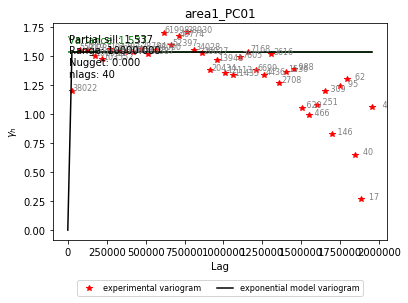

Calculating statistics on variogram model fit...


D:\OneDrive\Documenten\Programming\Python\Jupyter_Notebooks\PROJECTS\2019_04_05_Vistelius_OCR\_ANALYSIS\pykrige\core.py:726: RuntimeWarning: invalid value encountered in sqrt
  sigma[i] = np.sqrt(ss)


LinAlgError: Singular matrix

In [51]:
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.iloc[:, int(component[-1])-1].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=True,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name)
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [ ]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results")

**The error below should be fixed now. --> Confirmed, but other error due to NaN values? --> Actual error is also related to linalg error from above**

**The cv_param°dict has been rewritten so that the parameters can be set for each PC.  
Was not sure about the numbers of PCs that you are going to use so I quickly created a loop since the parameters you use aree the same over all PCs (except for variogram_model_parameters).**

**Also made a small change in the function that gets called.  
Basically what happened was that a list was being passed with one item whereas it just expected that one item (without being in a list).  
So just added 'list_name[0]' in the function instead of 'list_name' and all should be good now.**

In [48]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["spherical", "exponential"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [critical_distance, range_[0], max_lag_distance]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [50]:
# Run CV and get estimators (using default MSE scorer)
estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs)

Fitting 1623 folds for each of 6 candidates, totalling 9738 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.8s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [ ]:
# E.g. check CV_results for PC01
# Check column 'mean_test_score' for results
# lower values are better since the scorer used is the Mean Squared Error (MSE)
CV_results["PC01"]

In [ ]:
# Save CV_results to pickle file for easy use later
preproc.save_obj(CV_results, "CV_results")

In [ ]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

## Calculating predictions for best model
____

In [115]:
estimators_final = {}

for component in mineralogy_pca_df.columns:
    for radius in [critical_distance, range_[0]]:
        for variable_to_fit in ["estimates", "variances"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [116]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

FileNotFoundError: [Errno 2] No such file or directory: '../_DATA/_obj/kriging_predictions.pkl'

In [ ]:
# You can again change the n_jobs to lower the #CPU cores used for parallel processing

kriging_predictions = {}

for component in mineralogy_pca_df.columns:
    for radius in [critical_distance, range_[0]]:
        for variable_to_fit in ["estimates", "variances"]:
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=number_of_control_points,
                                  n_jobs=-1,
                                  verbose=5)

In [ ]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [ ]:
kriging_estimates_df = {}

for radius in [critical_distance, range_[0]]:
    temp = {}
    
    for component in mineralogy_pca_df.columns:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = mineralogy_pca_df.columns
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

In [ ]:
kriging_variances_df = {}


for radius in [critical_distance, range_[0]]:
    temp = {}
    
    for component in mineralogy_pca_df.columns:
        key = f"{component}_{radius}_variances"
        temp[key] = kriging_predictions[key]
        
    kriging_variances_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_variances_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_variances_df[f"{radius}"].columns = mineralogy_pca_df.columns
    
    print(f"{radius}")
    kriging_variances_df[f"{radius}"].head()

In [ ]:
kriging_variances_mean_df = {}

for radius in [critical_distance, range_[0]]:
    kriging_variances_mean_df[f"{radius}"] = \
        kriging_variances_df[f"{radius}"].mean(axis=0)

    print(f"{radius}")
    kriging_variances_mean_df[f"{radius}"]

In [ ]:
kriging_estimates_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [ ]:
solutions_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [44]:
residuals_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [ ]:
for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/residuals_clr_{ncomp}_{radius}.xlsx")

In [ ]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [62]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Error budget
____

In [45]:
# A = mean squared prediction error
# B = nugget
# C = non-explained variance of model
error_budget = {}

for radius in [critical_distance, range_[0]]:
    for ncomp in range(mineralogy_pca_df.shape[1]):
        A = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)
        B = np.array(nugget_)[:ncomp].sum()
        C = A - B

        error_budget[f"{ncomp}_{radius}"] = [A, B, C]

In [ ]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["MSPE", 
                                                             "Nugget", 
                                                             "Non-expl var of model"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

In [63]:
error_budget_df.to_excel("../_RESULTS/Error_budget/error_budget.xlsx")

## Contour plots
____

In [49]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(130, 2)
(270039, 2)
539 501


(501, 539)

In [ ]:
mask_critical_distance[mask_critical_distance == 1].sum()

In [ ]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [52]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [53]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [ ]:
pluton_area_km2

____

In [55]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [126]:
%%time
interpolated_parallel = Parallel(n_jobs=-1)(delayed(
    OK_model.execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component, OK_model in variograms.items())

Wall time: 52.3 s


In [127]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [128]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [56]:
# Number of PCs to use for reverse calculations
n_comp

interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(pca_BM, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

1
2
3
(3, 501, 539)


C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [58]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [132]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,)

(501, 539)
Q
(501, 539)
P
(501, 539)
K
(501, 539)
Others


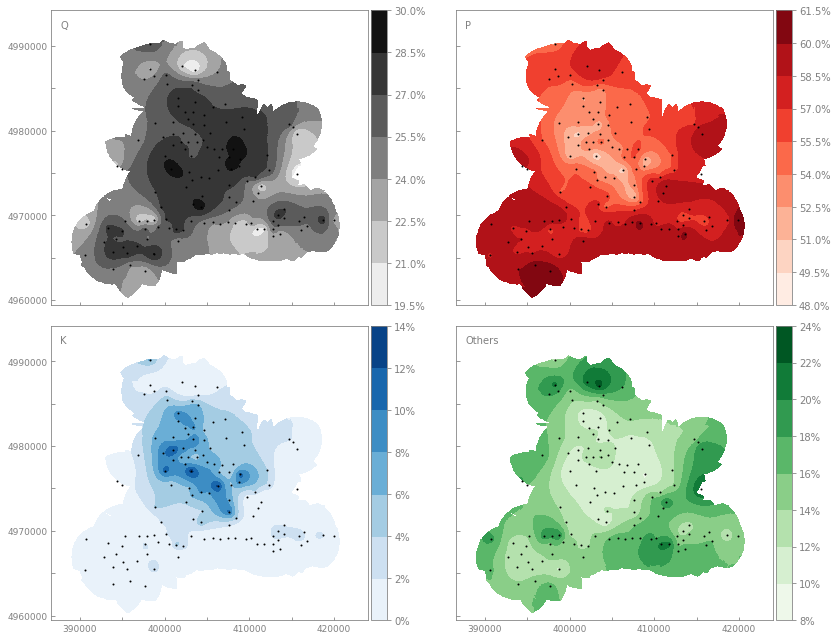

In [133]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid_wide,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now